# Seismic interpolation with spatial gradient and Radon sparsity transform

### Author: M.Ravasi

In this notebook we consider the problem of seismic reconstruction of coarsely regularly sampled data. We combine the following 3 ingredients to constrain the inverse problem to a satisfactory solution:

- gradient recordings (1st and 2nd derivative)
- Radon preconditioner
- Directional filtering with local slopes.

Following the work of Jingming Ruan and Ivan Vasconcelos (https://library.seg.org/doi/10.1190/segam2019-3216425.1) we write the forward modelling as follows:

$$
        \begin{bmatrix}
           \mathbf{d}_{tx}  \\
           \dot{s}\dot{\mathbf{d}_{tx}} \\
           \ddot{s}\ddot{\mathbf{d}_{tx}}
        \end{bmatrix} =
        \begin{bmatrix}
           \mathbf{R} \\
           \dot{s}\mathbf{R} \mathbf{F}^H \mathbf{D_1} \\
           \ddot{s}\mathbf{R} \mathbf{F}^H \mathbf{D_2}
        \end{bmatrix}
        \mathbf{d}_{fk}
$$

where the second and third equations are for the first and second spatial derivatives, and $\mathbf{D}_1$ and $\mathbf{D}_2$ are the operators that apply the spatial derivatives in the f-k domain. Note that since the derivative data $\dot{\mathbf{d}_t}$ and $\ddot{\mathbf{d}_t}$ may have different dynamical range from the data
$\mathbf{d}$, we scale these equations on both sides of the equal sign so that inversion will not favour matching $\mathbf{d}$ over the other two datasets.

Adding the preconditioner ($\mathbf{P}$) and directional filtering penalty ($\mathbf{D}_{||}$) accounts to modify the original problem as:

$$
        \begin{bmatrix}
           \mathbf{d}_t  \\
           \dot{s}\dot{\mathbf{d}_{tx}}  \\
           \ddot{s}\ddot{\mathbf{d}_{tx}} \\
           \mathbf{0}
        \end{bmatrix} =
        \begin{bmatrix}
           \mathbf{R} \\
           \dot{s}\mathbf{R} \mathbf{F}^H \mathbf{D_1} \\
           \ddot{s}\mathbf{R} \mathbf{F}^H \mathbf{D_2}  \\
           \epsilon \mathbf{D}_{||}
        \end{bmatrix} \mathbf{F} \mathbf{P}
        \mathbf{d}_{\tau p}
$$

In [110]:
%load_ext memory_profiler
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.io as sp_io

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import bicgstab, lsqr
from scipy.signal import convolve, fftconvolve, filtfilt, hilbert
from scipy.ndimage import median_filter

from pylops                            import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.waveeqprocessing.marchenko import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *
from pylops.utils.signalprocessing     import slope_estimate

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load input data

In [111]:
inputfile = '../../pylops/testdata/marchenko/input.npz'
inputdata = np.load(inputfile)

dorig = inputdata['R'][50, :, :-100]
dorig = dorig / np.abs(dorig).max()

t, x = inputdata['t'][:-100], inputdata['r'][0]
dt = t[1]-t[0]
dx = x[1]-x[0]
nr, nt = dorig.shape

# add wavelet
wav = inputdata['wav']
wav_c = np.argmax(wav)
dorig = np.apply_along_axis(convolve, 1, dorig, wav, mode='full')
dorig = dorig[:, wav_c:][:, :nt]

dorig = dorig.T

Apply gain (to be removed at the end) so that events at later times are enhanched and more equally reconstructed

In [112]:
gain = np.exp(2*t)
d = dorig * gain[:, np.newaxis]

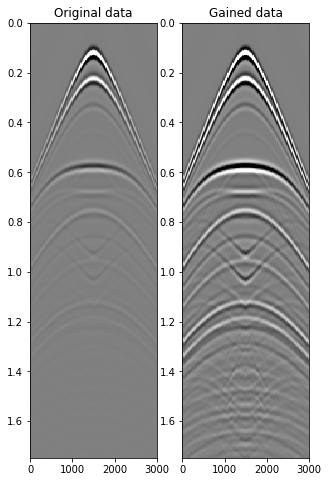

In [113]:
fig, axs = plt.subplots(1, 2, figsize=(5, 8))
axs[0].imshow(dorig, cmap='gray', aspect='auto', vmin=-1, vmax=1,
                    extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Original data')
axs[1].imshow(d, cmap='gray', aspect='auto', vmin=-1, vmax=1,
                    extent=(x[0], x[-1], t[-1], t[0]))
axs[1].set_title('Gained data');

Compute fk spectrum

In [5]:
F = FFT2D(dims=(nt, nr), nffts=(nt, nr), dtype=np.float)

D = F * d.ravel()
dadj = F.H * D

D = D.reshape(nt, nr)

Create restriction operator

In [6]:
subsampling = 6
print('dx', dx*subsampling)
idr = np.arange(0, nr, subsampling)
cod = np.arange(0,nt*nr).reshape(nt, nr)
idx = cod[:, idr].flatten()

R = Restriction(nt*nr, idx)
d_dec = R * d.ravel()

dadj = R.H * d_dec
dadj = dadj.reshape(nt, nr)

dx 180.0


Compute spatial derivatives of input data

In [7]:
ks = np.fft.fftfreq(nr, dx)
f = np.fft.fftfreq(nt, dt)

coeff1 = 1j*2*np.pi*ks
coeff2 = -(2*np.pi*ks)**2

coeff1_m = np.tile(coeff1, nt)
coeff2_m = np.tile(coeff2, nt)

D1op_hand = Diagonal(coeff1_m)
D2op_hand = Diagonal(coeff2_m)

#D1op_hand = Diagonal(coeff1, dims=(nt, nr), dir=1)
#D2op_hand = Diagonal(coeff2, dims=(nt, nr), dir=1)

D1 = D1op_hand * D.ravel()
D2 = D2op_hand * D.ravel()

d1 = F.H * D1
d2 = F.H * D2

d1 = d1.reshape(nt,nr)
d2 = d2.reshape(nt,nr)

sc1 = np.max(np.abs(d)) / np.max(np.abs(d1))
sc2 = np.max(np.abs(d)) / np.max(np.abs(d2))
print(sc1, sc2)

32.74583974669486 590.1628964196526


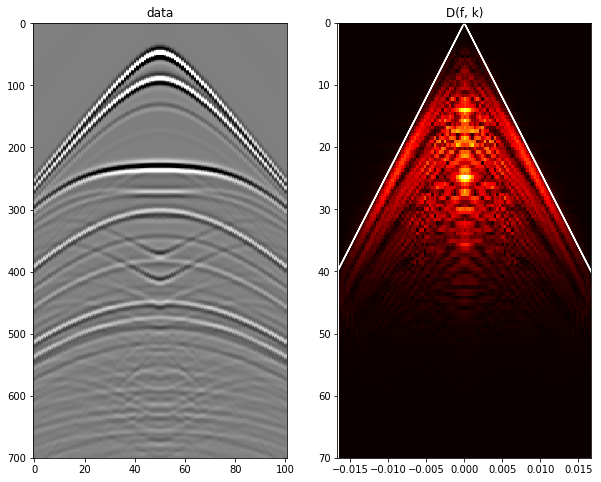

In [8]:
v = 2400 # water velocity

fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(np.real(d), cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[0].set_title('data')
axs[1].imshow(np.abs(np.fft.fftshift(D.reshape(nt, nr)))[nt//2:], 
              cmap='hot', aspect='auto', 
              extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1].plot(f/v, f,'w'), axs[1].plot(f/v, -f,'w')
axs[1].set_title('D(f, k)')
axs[1].set_xlim(-1/(2*dx), 1/(2*dx));
axs[1].set_ylim(70, 0);

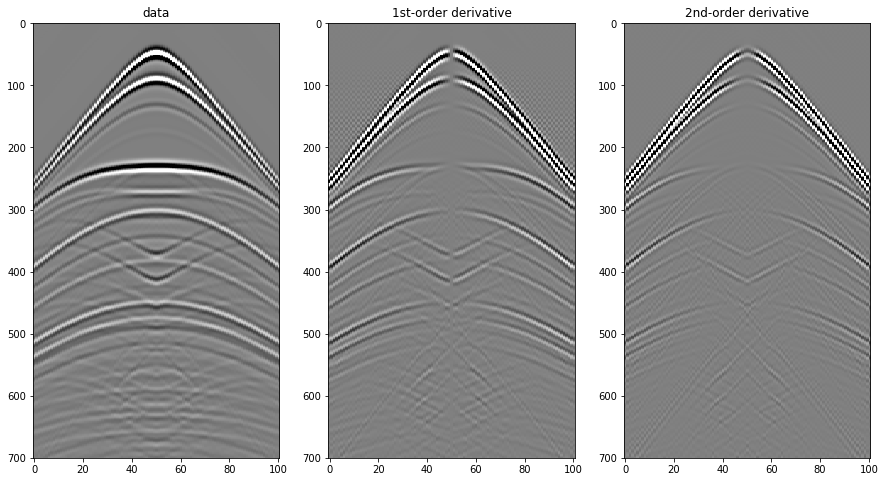

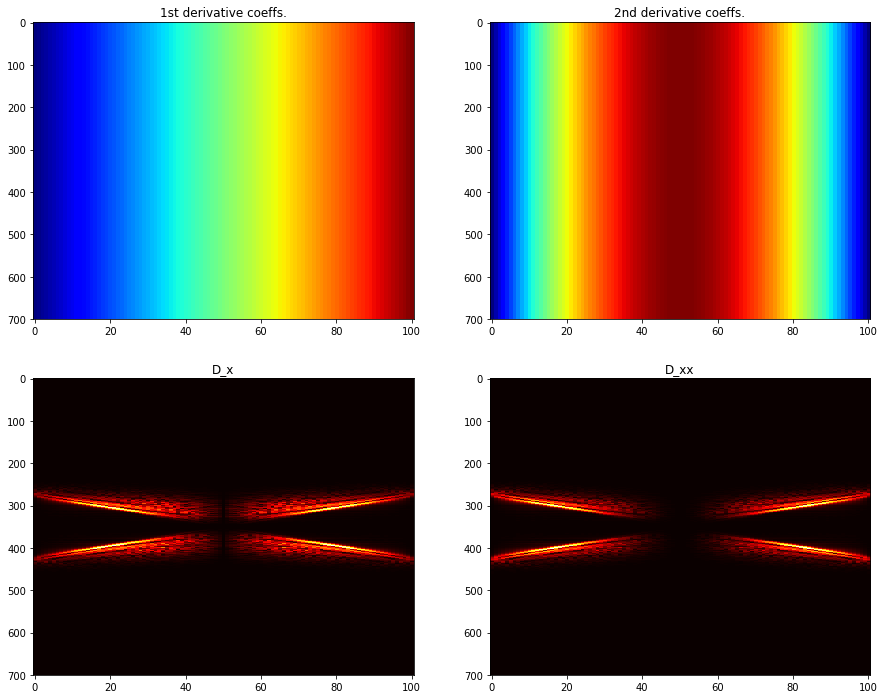

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
axs[0].imshow(np.real(d), cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[0].set_title('data')
axs[1].imshow(sc1 * np.real(d1), cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[1].set_title('1st-order derivative')
axs[2].imshow(sc2 * np.real(d2), cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[2].set_title('2nd-order derivative')

fig, axs = plt.subplots(2, 2, figsize=(15, 12))
axs[0][0].imshow(np.imag(np.fft.fftshift(coeff1_m.reshape(nt, nr))), 
                 cmap='jet', aspect='auto')
axs[0][0].set_title('1st derivative coeffs.')
axs[0][1].imshow(np.real(np.fft.fftshift(coeff2_m.reshape(nt, nr))), 
                 cmap='jet', aspect='auto')
axs[0][1].set_title('2nd derivative coeffs.')
axs[1][0].imshow(np.abs(np.fft.fftshift(D1.reshape(nt, nr))), 
                 cmap='hot', aspect='auto')
axs[1][0].set_title('D_x');
axs[1][1].imshow(np.abs(np.fft.fftshift(D2.reshape(nt, nr))), 
                 cmap='hot', aspect='auto')
axs[1][1].set_title('D_xx');

## Inversion with FK sparsity transform - no other contraints

In [10]:
d2_dec = np.real(R * d2.ravel())
d1_dec = np.real(R * d1.ravel())

Forward = R * F.H
rhs = d_dec

Forward1 = VStack([R*F.H, sc1*R*F.H*D1op_hand])
rhs1 = np.concatenate((d_dec, sc1*d1_dec))

Forward2 = VStack([R*F.H, sc1*R*F.H*D1op_hand, sc2*R*F.H*D2op_hand])
rhs2 = np.concatenate((d_dec, sc1*d1_dec, sc2*d2_dec), axis=0)

dinv = \
    RegularizedInversion(Forward, [], rhs, 
                         **dict(damp=0, iter_lim=200, show=1))

dinv1 = \
    RegularizedInversion(Forward1, [], rhs1, 
                         **dict(damp=0, iter_lim=200, show=1))

dinv2 = \
    RegularizedInversion(Forward2, [], rhs2, 
                         **dict(damp=0, iter_lim=200, show=1))

# back to time
dinv = np.real(F.H * dinv).reshape(nt,nr)
dinv1 = np.real(F.H * dinv1).reshape(nt,nr)
dinv2 = np.real(F.H * dinv2).reshape(nt,nr)

#pinv_s, _, info = SPGL1(Forward, rhs, **dict(iter_lim=500, verbosity=2))
#pinv1_s, _, info = SPGL1(Forward1, rhs1, **dict(iter_lim=500, verbosity=2))
#pinv2_s, _, info2 = SPGL1(Forward2, rhs2, **dict(iter_lim=500, verbosity=2))
pinv_s, _, cost = FISTA(Forward, rhs, niter=100, eps=1e-1, 
                        eigsiter=5, eigstol=1e-2,
                        returninfo=True, show=True)
pinv1_s, _, cost1 = FISTA(Forward1, rhs1, niter=100, eps=1e-1, 
                          eigsiter=5, eigstol=1e-2,
                          returninfo=True, show=True)
pinv2_s, _, cost2 = FISTA(Forward2, rhs2, niter=100, eps=1e-1, 
                          eigsiter=5, eigstol=1e-2,
                          returninfo=True, show=True)

dinv_s = np.real(F.H * pinv_s).reshape(nt, nr)
dinv1_s = np.real(F.H * pinv1_s).reshape(nt, nr)
dinv2_s = np.real(F.H * pinv2_s).reshape(nt, nr)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has    11900 rows  and    70700 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      200
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.766e+01  2.766e+01    1.0e+00  3.6e-02
     1 -2.52153e-03   2.849e-14  2.849e-14    1.0e-15  9.9e-01   1.0e+00  1.0e+00
 
LSQR finished
Ax - b is small enough, given atol, btol                  
 
istop =       1   r1norm = 2.8e-14   anorm = 1.0e+00   arnorm = 2.8e-14
itn   =       1   r2norm = 2.8e-14   acond = 1.0e+00   xnorm  = 2.8e+01
 
 
LSQR            Least-squares solution of  Ax = b
The matrix A has    23800 rows  and    70700 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      200
 
   Itn      x[0]       r1norm     r2norm   

alpha = 8.412610e-02	thresh = 4.206305e-03
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   0.00000e+00   5.355e+02   6.113e+02   9.901e+00
     2   0.00000e+00   3.807e+02   4.837e+02   3.799e+00
     3   0.00000e+00   2.855e+02   4.104e+02   3.287e+00
     4   0.00000e+00   2.260e+02   3.695e+02   2.853e+00
     5   0.00000e+00   1.886e+02   3.480e+02   2.423e+00
     6   0.00000e+00   1.628e+02   3.356e+02   2.093e+00
     7   0.00000e+00   1.422e+02   3.264e+02   1.918e+00
     8   0.00000e+00   1.238e+02   3.179e+02   1.865e+00
     9   0.00000e+00   1.070e+02   3.103e+02   1.860e+00
    10   0.00000e+00   9.178e+01   3.038e+02   1.852e+00
    11   0.00000e+00   7.819e+01   2.988e+02   1.821e+00
    21   0.00000e+00   1.862e+01   3.007e+02   7.892e-01
    31   0.00000e+00   1.725e+01   2.946e+02   5.636e-01
    41   0.00000e+00   2.026e+01   2.868e+02   4.287e-01
    51   0.00000e+00   1.838e+01   2.863e+

### Visualization

In [11]:
D = np.fft.fftshift(np.fft.fft2(d))
Dadj = np.fft.fftshift(np.fft.fft2(dadj))
Dinv = np.fft.fftshift(np.fft.fft2(dinv))
Dinv1 = np.fft.fftshift(np.fft.fft2(dinv))
Dinv2 = np.fft.fftshift(np.fft.fft2(dinv2))
Dinv_s = np.fft.fftshift(np.fft.fft2(dinv_s))
Dinv1_s = np.fft.fftshift(np.fft.fft2(dinv_s))
Dinv2_s = np.fft.fftshift(np.fft.fft2(dinv2_s))

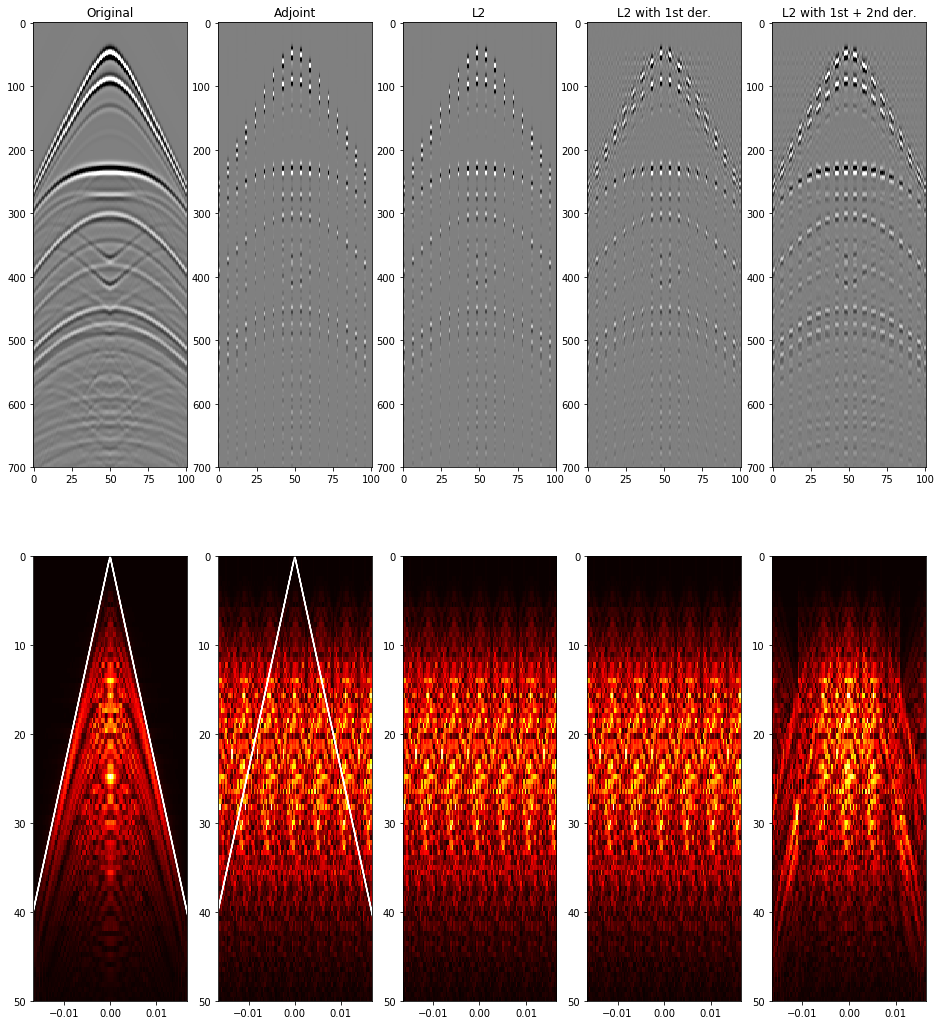

In [12]:
fig, axs = plt.subplots(2, 5, figsize=(16, 18))
axs[0,0].imshow(d, cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[0,0].set_title('Original')
axs[0,1].imshow(dadj, cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0,1].set_title('Adjoint')
axs[0,2].imshow(np.real(dinv),cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0,2].set_title('L2')
axs[0,3].imshow(np.real(dinv1),cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0,3].set_title('L2 with 1st der.')
axs[0,4].imshow(np.real(dinv2),cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0,4].set_title('L2 with 1st + 2nd der.')

axs[1,0].imshow(np.abs(D)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,0].plot(f/v, f,'w'), axs[1,0].plot(f/v, -f,'w')
axs[1,0].set_xlim(-1/(2*dx), 1/(2*dx));
axs[1,0].set_ylim(50, 0);
axs[1,1].imshow(np.abs(Dadj)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,1].plot(f/v, f,'w'), axs[1,1].plot(f/v, -f,'w')
axs[1,1].set_xlim(-1/(2*dx), 1/(2*dx));
axs[1,1].set_ylim(50, 0)
axs[1,2].imshow(np.abs(Dinv)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,2].set_ylim(50, 0)
axs[1,3].imshow(np.abs(Dinv1)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,3].set_ylim(50, 0)
axs[1,4].imshow(np.abs(Dinv2)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,4].set_ylim(50, 0);

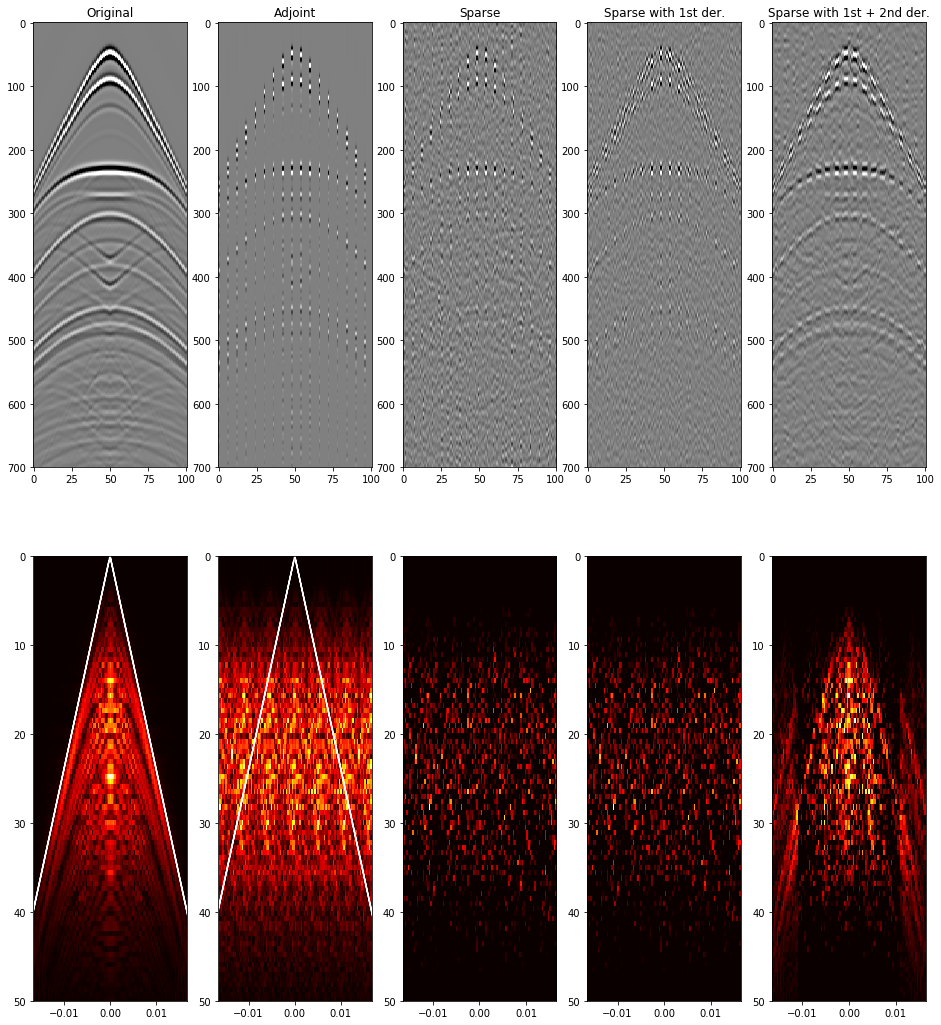

In [13]:
fig, axs = plt.subplots(2, 5, figsize=(16, 18))
axs[0,0].imshow(d, cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[0,0].set_title('Original')
axs[0,1].imshow(dadj, cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0,1].set_title('Adjoint')
axs[0,2].imshow(np.real(dinv_s),cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0,2].set_title('Sparse')
axs[0,3].imshow(np.real(dinv1_s),cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0,3].set_title('Sparse with 1st der.')
axs[0,4].imshow(np.real(dinv2_s),cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0,4].set_title('Sparse with 1st + 2nd der.')

axs[1,0].imshow(np.abs(D)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,0].plot(f/v, f,'w'), axs[1,0].plot(f/v, -f,'w')
axs[1,0].set_xlim(-1/(2*dx), 1/(2*dx));
axs[1,0].set_ylim(50, 0);
axs[1,1].imshow(np.abs(Dadj)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,1].plot(f/v, f,'w'), axs[1,1].plot(f/v, -f,'w')
axs[1,1].set_xlim(-1/(2*dx), 1/(2*dx));
axs[1,1].set_ylim(50, 0)
axs[1,2].imshow(np.abs(Dinv_s)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,2].set_ylim(50, 0)
axs[1,3].imshow(np.abs(Dinv1_s)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,3].set_ylim(50, 0)
axs[1,4].imshow(np.abs(Dinv2_s)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,4].set_ylim(50, 0);

### Errors

In [14]:
err_adj = np.linalg.norm(d-dadj)
err_ls_fk = np.linalg.norm(d-dinv)
err_ls1_fk = np.linalg.norm(d-dinv1)
err_ls2_fk = np.linalg.norm(d-dinv2)
err_inv_fk = np.linalg.norm(d-dinv_s)
err_inv1_fk = np.linalg.norm(d-dinv1_s)
err_inv2_fk = np.linalg.norm(d-dinv2_s)

print(err_adj)
print(err_ls_fk)
print(err_ls1_fk)
print(err_ls2_fk)
print(err_inv_fk)
print(err_inv1_fk)
print(err_inv2_fk)

61.60592724773835
61.60592724773835
59.41456271367147
53.3222075568043
68.89871162342766
69.46209270598362
52.163973632889004


## Inversion with Radon sparsity transform - no other contraints

In [15]:
nwin=25
nwins=6
nover=10
npx=401
pxmax = 1e-3
px = np.linspace(-pxmax, pxmax, npx)
dimsd = (nr, nt) 
dimss = (nwins*npx, dimsd[1])

# tranpose operator
Top = Transpose((nr, nt), axes=(1, 0), dtype=np.float64)

# sliding window radon with overlap
RadOp = Radon2D(t, np.linspace(-dx*nwin//2, dx*nwin//2, nwin), px, centeredh=True,
                kind='linear', engine='numba')
Slidop = Sliding2D(RadOp, dimss, dimsd, nwin, nover, tapertype='cosine', design=True)
dottest(Slidop, np.prod(dimsd), np.prod(dimss), verb=True);

Sparseop = Top * Slidop

Dot test passed, v^T(Opu)=-9875.481535 - u^T(Op^Tv)=-9875.481535


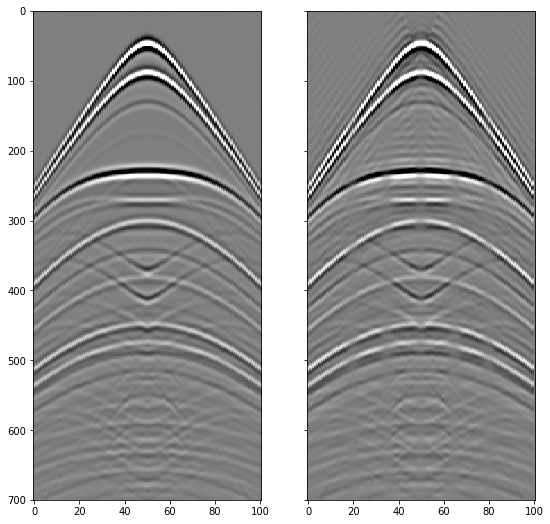

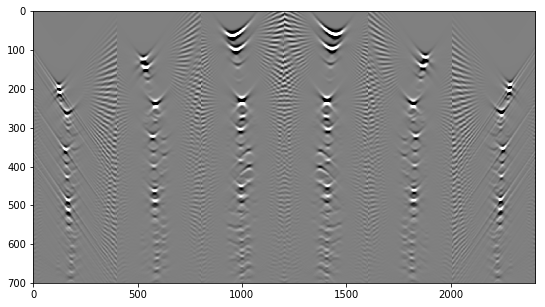

In [16]:
d_radon = Sparseop.H * d.ravel()
d_radon_adj = Sparseop * d_radon

d_radon = d_radon.reshape(npx*nwins, nt)
d_radon_adj = d_radon_adj.reshape(nt, nr)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(9, 9))
axs[0].imshow(d, cmap='gray', vmin=-1, vmax=1)
axs[0].axis('tight')
axs[1].imshow(d_radon_adj, cmap='gray', vmin=-3e2, vmax=3e2)
axs[1].axis('tight')
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.imshow(d_radon.T, cmap='gray', vmin=-5, vmax=5)
ax.axis('tight');

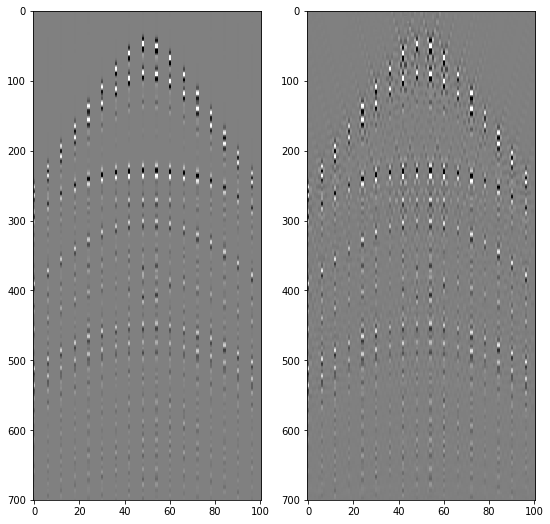

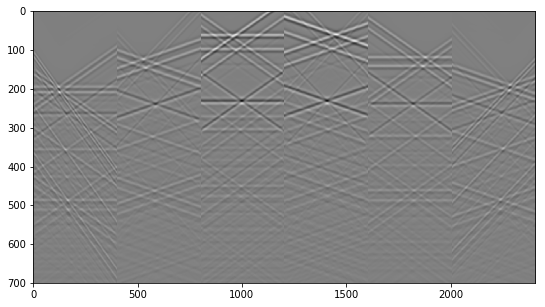

In [17]:
dadj_radon = Sparseop.H * dadj.ravel()
dadj_radon_adj = Sparseop * dadj_radon

dadj_radon = dadj_radon.reshape(npx*nwins, nt)
dadj_radon_adj = dadj_radon_adj.reshape(nt, nr)

fig, axs = plt.subplots(1, 2, figsize=(9, 9))
axs[0].imshow(dadj, cmap='gray', vmin=-1, vmax=1)
axs[0].axis('tight')
axs[1].imshow(dadj_radon_adj, cmap='gray', vmin=-3e2, vmax=3e2)
axs[1].axis('tight')

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.imshow(dadj_radon.T, cmap='gray', vmin=-5, vmax=5)
ax.axis('tight');

In [18]:
d2_dec = np.real(R * d2.ravel())
d1_dec = np.real(R * d1.ravel())

Forward = R * Sparseop
Forward.dtype = np.float
rhs = d_dec

Forward1 = VStack([R*F.H, sc1*R*F.H*D1op_hand]) * F * Sparseop
Forward1.dtype = np.float
rhs1 = np.concatenate((d_dec, sc1*d1_dec))

Forward2 = VStack([R*F.H, sc1*R*F.H*D1op_hand, sc2*R*F.H*D2op_hand]) * F * Sparseop
Forward2.dtype = np.float
rhs2 = np.concatenate((d_dec, sc1*d1_dec, sc2*d2_dec), axis=0)

#pinv_s, _, info = SPGL1(Forward, rhs, **dict(iter_lim=500, verbosity=2))
#pinv1_s, _, info = SPGL1(Forward1, rhs1, **dict(iter_lim=500, verbosity=2))
#pinv2_s, _, info2 = SPGL1(Forward2, rhs2, **dict(iter_lim=500, verbosity=2))
pinv_s, _, cost = FISTA(Forward, rhs, niter=100, eps=1e-1, 
                        eigsiter=5, eigstol=1e-2,
                        returninfo=True, show=True)
pinv1_s, _, cost1 = FISTA(Forward1, rhs1, niter=100, eps=1e-1, 
                          eigsiter=5, eigstol=1e-2,
                          returninfo=True, show=True)
pinv2_s, _, cost2 = FISTA(Forward2, rhs2, niter=100, eps=1e-1, 
                          eigsiter=5, eigstol=1e-2,
                          returninfo=True, show=True)

dinv_s = np.real(Slidop * pinv_s).reshape(nr,nt).T
dinv1_s = np.real(Slidop * pinv1_s).reshape(nr,nt).T
dinv2_s = np.real(Slidop * pinv2_s).reshape(nr,nt).T

FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 11900 rows and 1684200 cols
eps = 1.000000e-01	tol = 1.000000e-10	niter = 100
alpha = 7.210968e-04	thresh = 3.605484e-05
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   0.00000e+00   2.311e+02   2.547e+02   3.397e-01
     2   0.00000e+00   1.444e+02   1.853e+02   2.535e-01
     3   0.00000e+00   8.125e+01   1.385e+02   2.450e-01
     4   0.00000e+00   4.196e+01   1.129e+02   2.144e-01
     5   0.00000e+00   2.045e+01   1.017e+02   1.741e-01
     6   0.00000e+00   9.800e+00   9.793e+01   1.336e-01
     7   0.00000e+00   4.914e+00   9.683e+01   9.923e-02
     8   0.00000e+00   2.840e+00   9.615e+01   7.385e-02
     9   0.00000e+00   2.101e+00   9.513e+01   5.759e-02
    10   0.00000e+00   1.981e+00   9.374e+01   4.877e-02
    11   0.00000e+00   2.114e+00   9.211e+01   4.501e-02
    21   0.00000

### Visualization

In [19]:
D = np.fft.fftshift(np.fft.fft2(d))
Dadj = np.fft.fftshift(np.fft.fft2(dadj))
Dinv_s = np.fft.fftshift(np.fft.fft2(dinv_s))
Dinv1_s = np.fft.fftshift(np.fft.fft2(dinv_s))
Dinv2_s = np.fft.fftshift(np.fft.fft2(dinv2_s))

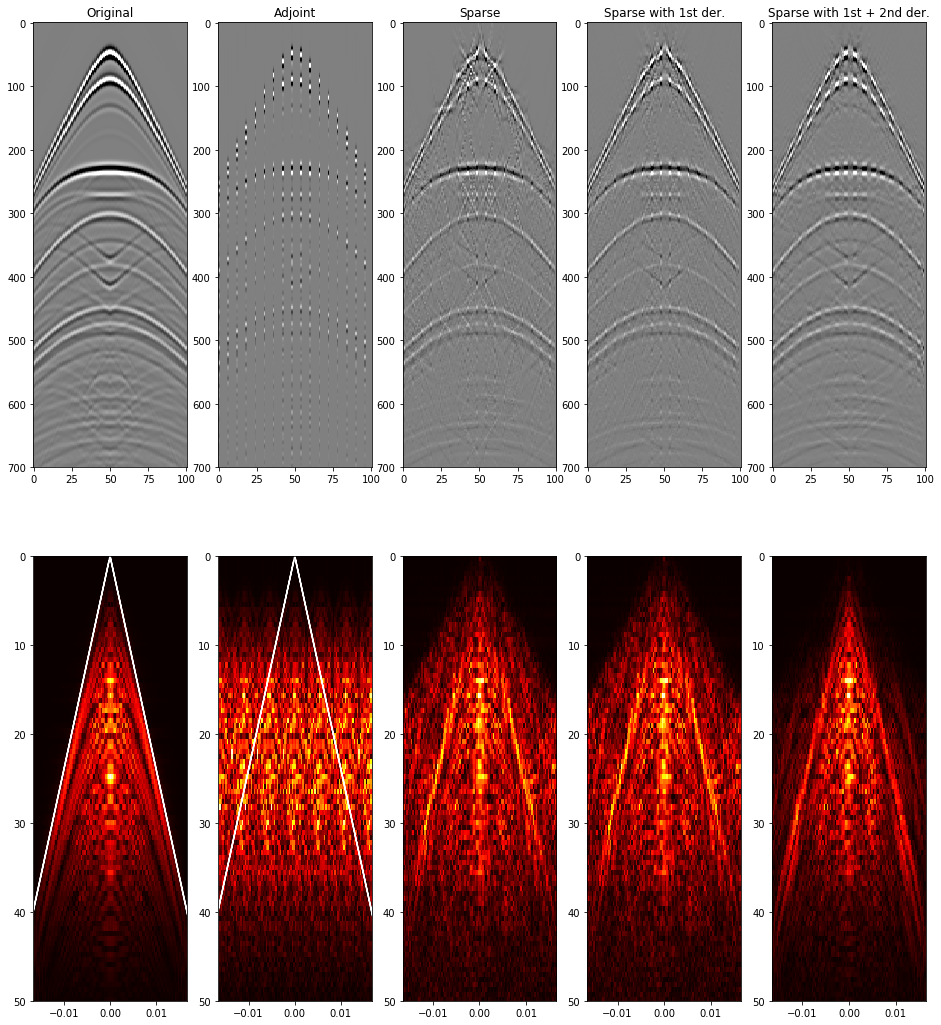

In [20]:
fig, axs = plt.subplots(2, 5, figsize=(16, 18))
axs[0,0].imshow(d, cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[0,0].set_title('Original')
axs[0,1].imshow(dadj, cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0,1].set_title('Adjoint')
axs[0,2].imshow(np.real(dinv_s),cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0,2].set_title('Sparse')
axs[0,3].imshow(np.real(dinv1_s),cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0,3].set_title('Sparse with 1st der.')
axs[0,4].imshow(np.real(dinv2_s),cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0,4].set_title('Sparse with 1st + 2nd der.')

axs[1,0].imshow(np.abs(D)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,0].plot(f/v, f,'w'), axs[1,0].plot(f/v, -f,'w')
axs[1,0].set_xlim(-1/(2*dx), 1/(2*dx));
axs[1,0].set_ylim(50, 0);
axs[1,1].imshow(np.abs(Dadj)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,1].plot(f/v, f,'w'), axs[1,1].plot(f/v, -f,'w')
axs[1,1].set_xlim(-1/(2*dx), 1/(2*dx));
axs[1,1].set_ylim(50, 0)
axs[1,2].imshow(np.abs(Dinv_s)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,2].set_ylim(50, 0)
axs[1,3].imshow(np.abs(Dinv1_s)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,3].set_ylim(50, 0)
axs[1,4].imshow(np.abs(Dinv2_s)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,4].set_ylim(50, 0);

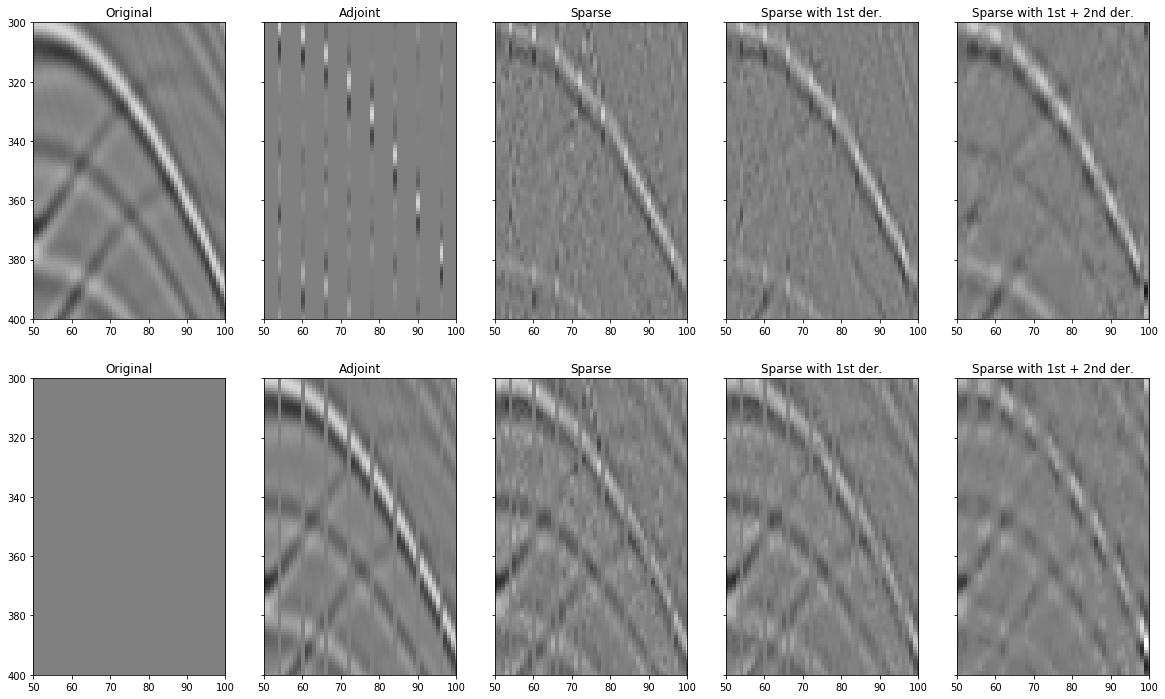

In [21]:
fig, axs = plt.subplots(2, 5, sharey=True, figsize=(20, 12))
axs[0, 0].imshow(d, cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[0, 0].set_title('Original')
axs[0, 0].set_xlim(50, 100)
axs[0, 1].imshow(dadj, cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0, 1].set_title('Adjoint')
axs[0, 1].set_xlim(50, 100)
axs[0, 2].imshow(np.real(dinv_s), cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0, 2].set_title('Sparse')
axs[0, 2].set_xlim(50, 100)
axs[0, 3].imshow(np.real(dinv1_s), cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0, 3].set_title('Sparse with 1st der.')
axs[0, 3].set_xlim(50, 100)
axs[0, 4].imshow(np.real(dinv2_s), cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0, 4].set_title('Sparse with 1st + 2nd der.')
axs[0, 4].set_xlim(50, 100)
axs[0, 4].set_ylim(400, 300)

axs[1, 0].imshow(d-d, cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[1, 0].set_title('Original')
axs[1, 0].set_xlim(50, 100)
axs[1, 1].imshow(d-dadj, cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[1, 1].set_title('Adjoint')
axs[1, 1].set_xlim(50, 100)
axs[1, 2].imshow(d-np.real(dinv_s), cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[1, 2].set_title('Sparse')
axs[1, 2].set_xlim(50, 100)
axs[1, 3].imshow(d-np.real(dinv1_s), cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[1, 3].set_title('Sparse with 1st der.')
axs[1, 3].set_xlim(50, 100)
axs[1, 4].imshow(d-np.real(dinv2_s), cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[1, 4].set_title('Sparse with 1st + 2nd der.')
axs[1, 4].set_xlim(50, 100)
axs[1, 4].set_ylim(400, 300);

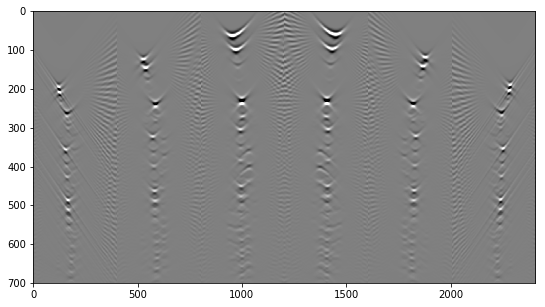

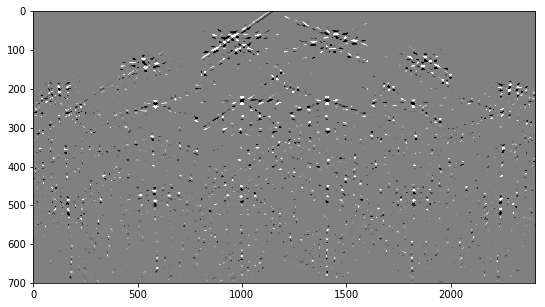

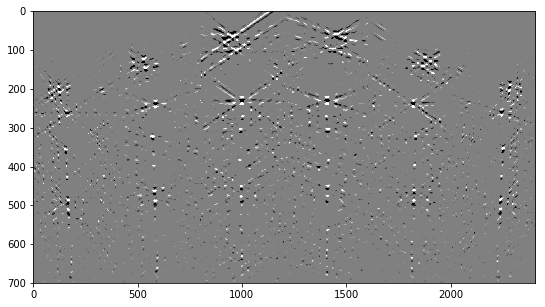

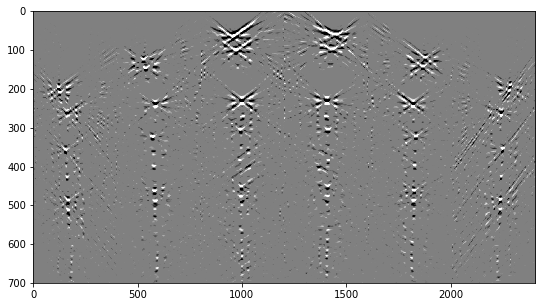

In [22]:
pinv_s = pinv_s.reshape(npx*nwins, nt)
pinv1_s = pinv1_s.reshape(npx*nwins, nt)
pinv2_s = pinv2_s.reshape(npx*nwins, nt)

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.imshow(d_radon.T, cmap='gray', vmin=-1e1, vmax=1e1)
ax.axis('tight');

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.imshow(pinv_s.T, cmap='gray', vmin=-1e-2, vmax=1e-2)
ax.axis('tight');

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.imshow(pinv1_s.T, cmap='gray', vmin=-1e-2, vmax=1e-2)
ax.axis('tight');

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.imshow(pinv2_s.T, cmap='gray', vmin=-1e-2, vmax=1e-2)
ax.axis('tight');

### Errors

In [23]:
err_adj = np.linalg.norm(d-dadj)
err_inv = np.linalg.norm(d-dinv_s)
err_inv1 = np.linalg.norm(d-dinv1_s)
err_inv2 = np.linalg.norm(d-dinv2_s)

print(err_inv)
print(err_inv1)
print(err_inv2)

49.89412960736007
44.916081460164115
40.172580556205155


## Inversion with frequency domain masks

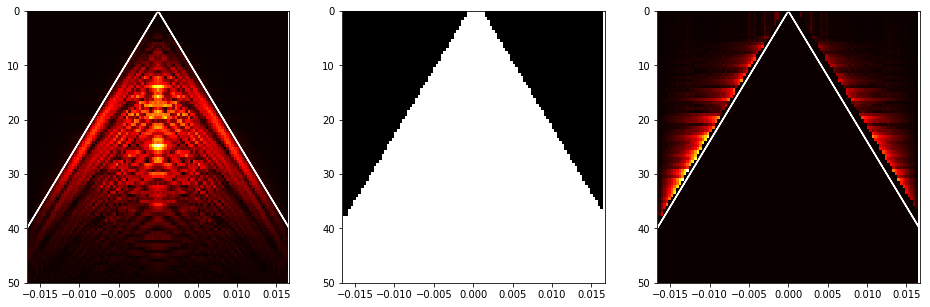

In [24]:
critical = 1.00
koffset = 0.001
vel = 2400.
fmax = 70

fmask = np.zeros(nt)
fmask[np.abs(f)<fmax] = 1

[kx, ff] = np.meshgrid(ks, f, indexing='ij')
mask = np.abs(kx) < (critical*np.abs(ff)/vel + koffset)
mask = mask.T
mask *= fmask[:, np.newaxis].astype(bool)
mask = mask.astype(np.int)
Mf = Diagonal(mask.astype(np.int))

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(np.abs(D)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[0].plot(f/v, f,'w'), axs[0].plot(f/v, -f,'w')
axs[0].set_xlim(-1/(2*dx), 1/(2*dx));
axs[0].set_ylim(50, 0);
axs[1].imshow(np.fft.ifftshift(mask)[nt//2:], cmap='gray',aspect='auto',
              extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1].plot(f/v, f,'w'), axs[1].plot(f/v, -f,'w')
axs[1].set_xlim(-1/(2*dx), 1/(2*dx));
axs[1].set_ylim(50, 0)
axs[2].imshow(((1-np.fft.ifftshift(mask))*np.abs(D))[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[2].plot(f/v, f,'w'), axs[2].plot(f/v, -f,'w')
axs[2].set_xlim(-1/(2*dx), 1/(2*dx));
axs[2].set_ylim(50, 0);

In [25]:
d2_dec = np.real(R * d2.ravel())
d1_dec = np.real(R * d1.ravel())

Forward = R * F.H * Mf * F * Sparseop
Forward.dtype = np.float
rhs = d_dec

Forward1 = VStack([R*F.H, sc1*R*F.H*D1op_hand]) * Mf * F * Sparseop
Forward1.dtype = np.float
rhs1 = np.concatenate((d_dec, sc1*d1_dec))

Forward2 = VStack([R*F.H, sc1*R*F.H*D1op_hand, sc2*R*F.H*D2op_hand]) * Mf * F * Sparseop
Forward2.dtype = np.float
rhs2 = np.concatenate((d_dec, sc1*d1_dec, sc2*d2_dec), axis=0)

# sparse solution
#pinv1_s, pspgl, info = SPGL1(Forward1, rhs1, **dict(iter_lim=100, verbosity=2))
#pinv2_s, pspgl2, info2 = SPGL1(Forward2, rhs2, **dict(iter_lim=100, verbosity=2))
pinv_s, _, cost = FISTA(Forward, rhs, niter=100, eps=1e-1, 
                          eigsiter=5, eigstol=1e-2,
                          returninfo=True, show=True)
pinv1_s, _, cost = FISTA(Forward1, rhs1, niter=100, eps=1e-1, 
                          eigsiter=5, eigstol=1e-2,
                          returninfo=True, show=True)
pinv2_s, _, cost2 = FISTA(Forward2, rhs2, niter=100, eps=1e-1, 
                          eigsiter=5, eigstol=1e-2,
                          returninfo=True, show=True)

dinv_s = np.real(F.H * Mf * F * Sparseop * pinv_s).reshape(nt,nr)
dinv1_s = np.real(F.H * Mf * F * Sparseop * pinv1_s).reshape(nt,nr)
dinv2_s = np.real(F.H * Mf * F * Sparseop * pinv2_s).reshape(nt,nr)

FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 11900 rows and 1684200 cols
eps = 1.000000e-01	tol = 1.000000e-10	niter = 100
alpha = 8.238772e-04	thresh = 4.119386e-05
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   0.00000e+00   2.770e+02   2.963e+02   2.951e-01
     2   0.00000e+00   2.052e+02   2.397e+02   2.408e-01
     3   0.00000e+00   1.425e+02   1.925e+02   2.550e-01
     4   0.00000e+00   9.348e+01   1.579e+02   2.497e-01
     5   0.00000e+00   5.848e+01   1.352e+02   2.314e-01
     6   0.00000e+00   3.519e+01   1.218e+02   2.056e-01
     7   0.00000e+00   2.066e+01   1.146e+02   1.767e-01
     8   0.00000e+00   1.209e+01   1.109e+02   1.481e-01
     9   0.00000e+00   7.302e+00   1.088e+02   1.222e-01
    10   0.00000e+00   4.758e+00   1.073e+02   1.007e-01
    11   0.00000e+00   3.473e+00   1.058e+02   8.466e-02
    21   0.00000

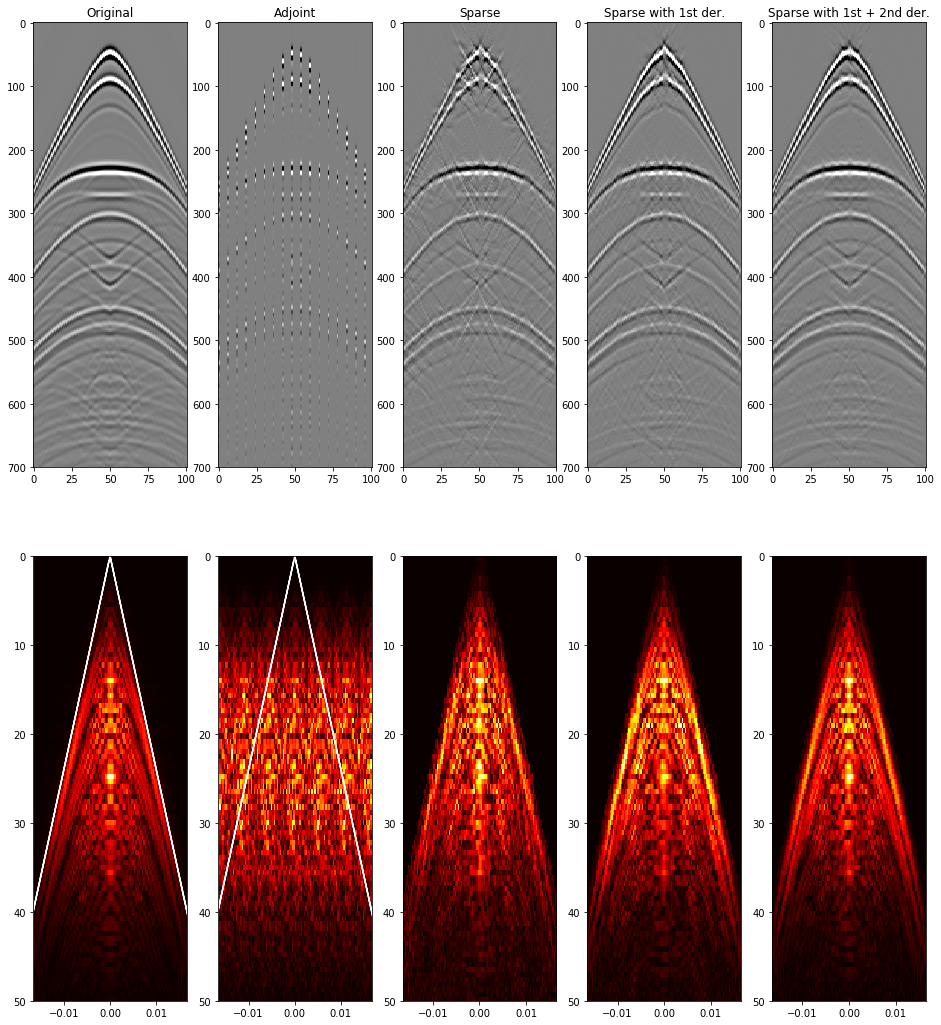

In [26]:
D = np.fft.fftshift(np.fft.fft2(d))
Dadj = np.fft.fftshift(np.fft.fft2(dadj))
Dinv_s = np.fft.fftshift(np.fft.fft2(dinv_s))
Dinv1_s = np.fft.fftshift(np.fft.fft2(dinv1_s))
Dinv2_s = np.fft.fftshift(np.fft.fft2(dinv2_s))


fig, axs = plt.subplots(2, 5, figsize=(16, 18))
axs[0,0].imshow(d, cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[0,0].set_title('Original')
axs[0,1].imshow(dadj, cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0,1].set_title('Adjoint')
axs[0,2].imshow(np.real(dinv_s),cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0,2].set_title('Sparse')
axs[0,3].imshow(np.real(dinv1_s),cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0,3].set_title('Sparse with 1st der.')
axs[0,4].imshow(np.real(dinv2_s),cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0,4].set_title('Sparse with 1st + 2nd der.')

axs[1,0].imshow(np.abs(D)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,0].plot(f/v, f,'w'), axs[1,0].plot(f/v, -f,'w')
axs[1,0].set_xlim(-1/(2*dx), 1/(2*dx));
axs[1,0].set_ylim(50, 0);
axs[1,1].imshow(np.abs(Dadj)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,1].plot(f/v, f,'w'), axs[1,1].plot(f/v, -f,'w')
axs[1,1].set_xlim(-1/(2*dx), 1/(2*dx));
axs[1,1].set_ylim(50, 0)
axs[1,2].imshow(np.abs(Dinv_s)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,2].set_ylim(50, 0)
axs[1,3].imshow(np.abs(Dinv1_s)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,3].set_ylim(50, 0)
axs[1,4].imshow(np.abs(Dinv2_s)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,4].set_ylim(50, 0);

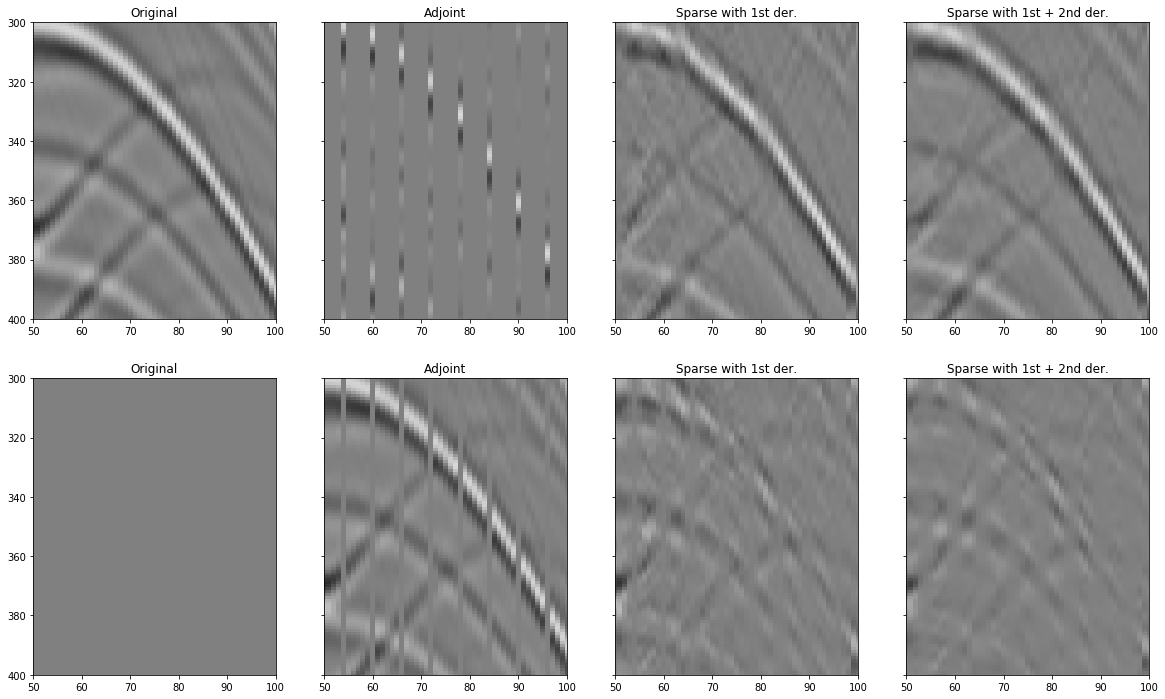

In [27]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(20, 12))
axs[0, 0].imshow(d, cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[0, 0].set_title('Original')
axs[0, 0].set_xlim(50, 100)
axs[0, 1].imshow(dadj, cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0, 1].set_title('Adjoint')
axs[0, 1].set_xlim(50, 100)
axs[0, 2].imshow(np.real(dinv1_s), cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0, 2].set_title('Sparse with 1st der.')
axs[0, 2].set_xlim(50, 100)
axs[0, 3].imshow(np.real(dinv2_s), cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0, 3].set_title('Sparse with 1st + 2nd der.')
axs[0, 3].set_xlim(50, 100)
axs[0, 3].set_ylim(400, 300)
axs[1, 0].imshow(d-d, cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[1, 0].set_title('Original')
axs[1, 0].set_xlim(50, 100)
axs[1, 1].imshow(d-dadj, cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[1, 1].set_title('Adjoint')
axs[1, 1].set_xlim(50, 100)
axs[1, 2].imshow(d-np.real(dinv1_s), cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[1, 2].set_title('Sparse with 1st der.')
axs[1, 2].set_xlim(50, 100)
axs[1, 3].imshow(d-np.real(dinv2_s), cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[1, 3].set_title('Sparse with 1st + 2nd der.')
axs[1, 3].set_xlim(50, 100)
axs[1, 3].set_ylim(400, 300);

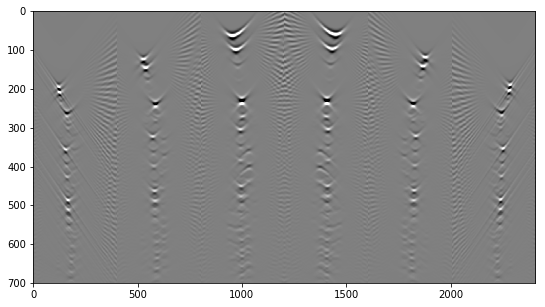

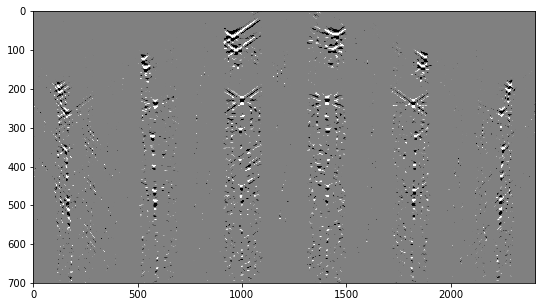

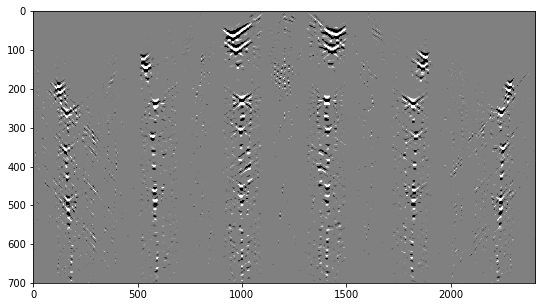

In [28]:
pinv1_s = pinv1_s.reshape(npx*nwins, nt)
pinv2_s = pinv2_s.reshape(npx*nwins, nt)

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.imshow(d_radon.T, cmap='gray', vmin=-1e1, vmax=1e1)
ax.axis('tight');

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.imshow(pinv1_s.T, cmap='gray', vmin=-1e-2, vmax=1e-2)
ax.axis('tight');

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.imshow(pinv2_s.T, cmap='gray', vmin=-1e-2, vmax=1e-2)
ax.axis('tight');

### Errors

In [29]:
err_inv_f = np.linalg.norm(d-dinv_s)
err_inv1_f = np.linalg.norm(d-dinv1_s)
err_inv2_f = np.linalg.norm(d-dinv2_s)

print(err_inv_f)
print(err_inv1_f)
print(err_inv2_f)

39.75052721238027
29.611741614804863
20.88606248091099


## Inversion with frequency and time domain masks

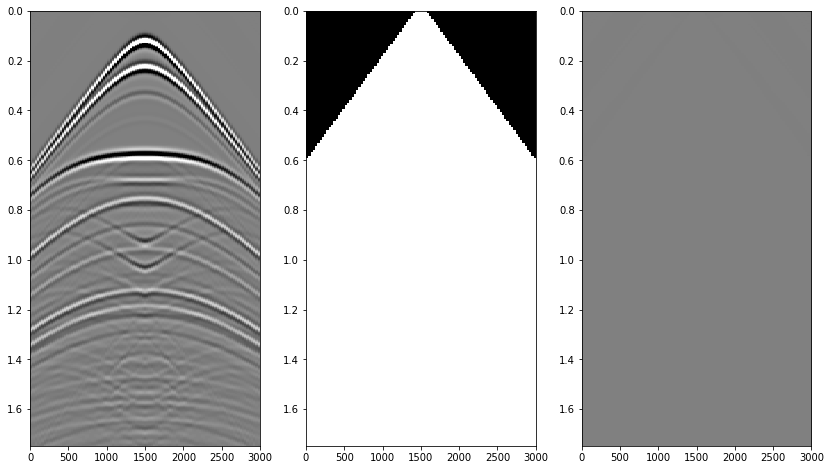

In [30]:
x0 = 1500
[xx, tt] = np.meshgrid(x, t, indexing='ij')
tmask = np.zeros((nt, nr))
for ir in range(nr):
    tdir = np.abs(x[ir]-x0) / vel - 0.03
    tmask[max(0, int(tdir/dt)):, ir] = 1
Mt = Diagonal(tmask.ravel())

fig,axes = plt.subplots(1, 3, figsize=(14, 8))
axes[0].imshow(d, cmap='gray',aspect='auto', vmin=-1, vmax=1,
               extent=(x[0], x[-1], t[-1], t[0]))
axes[1].imshow(tmask, cmap='gray', aspect='auto',
               extent=(x[0], x[-1], t[-1], t[0]))
axes[2].imshow((1-tmask)*d, cmap='gray', aspect='auto', vmin=-1, vmax=1,
               extent=(x[0], x[-1], t[-1], t[0]));

In [31]:
d2_dec = np.real(R * d2.ravel())
d1_dec = np.real(R * d1.ravel())

Forward1 = VStack([R*Mt*F.H, sc1*R*Mt*F.H*D1op_hand]) * Mf * F * Sparseop
Forward1.dtype = np.float
rhs1 = np.concatenate((d_dec, sc1*d1_dec))

Forward2 = VStack([R*Mt*F.H, sc1*R*Mt*F.H*D1op_hand, sc2*R*Mt*F.H*D2op_hand]) * Mf * F * Sparseop
Forward2.dtype = np.float
rhs2 = np.concatenate((d_dec, sc1*d1_dec, sc2*d2_dec), axis=0)

# sparse solution
#pinv1_s, pspgl, info1 = SPGL1(Forward, rhs, **dict(iter_lim=100, verbosity=2))
#pinv2_s, pspgl2, info2 = SPGL1(Forward2, rhs2, **dict(iter_lim=100, verbosity=2))
pinv1_s, _, cost1 = FISTA(Forward1, rhs1, niter=100, eps=1e-1, 
                        eigsiter=5, eigstol=1e-2,
                        returninfo=True, show=True)
pinv2_s, _, cost2 = FISTA(Forward2, rhs2, niter=100, eps=1e-1, 
                          eigsiter=5, eigstol=1e-2,
                          returninfo=True, show=True)

dinv1_s = np.real(Mt * F.H * Mf * F * Sparseop * pinv1_s).reshape(nt, nr)
dinv2_s = np.real(Mt * F.H * Mf * F * Sparseop * pinv2_s).reshape(nt, nr)

FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 23800 rows and 1684200 cols
eps = 1.000000e-01	tol = 1.000000e-10	niter = 100
alpha = 6.073484e-04	thresh = 3.036742e-05
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1  -1.58955e-05   5.093e+02   5.401e+02   4.934e-01
     2  -2.70909e-06   3.690e+02   4.175e+02   3.033e-01
     3   0.00000e+00   2.640e+02   3.285e+02   2.934e-01
     4   0.00000e+00   1.855e+02   2.641e+02   2.799e-01
     5   0.00000e+00   1.279e+02   2.187e+02   2.623e-01
     6   0.00000e+00   8.683e+01   1.878e+02   2.409e-01
     7   0.00000e+00   5.831e+01   1.675e+02   2.173e-01
     8   0.00000e+00   3.908e+01   1.546e+02   1.929e-01
     9   0.00000e+00   2.647e+01   1.465e+02   1.692e-01
    10   0.00000e+00   1.840e+01   1.414e+02   1.470e-01
    11   0.00000e+00   1.336e+01   1.379e+02   1.272e-01
    21   0.00000

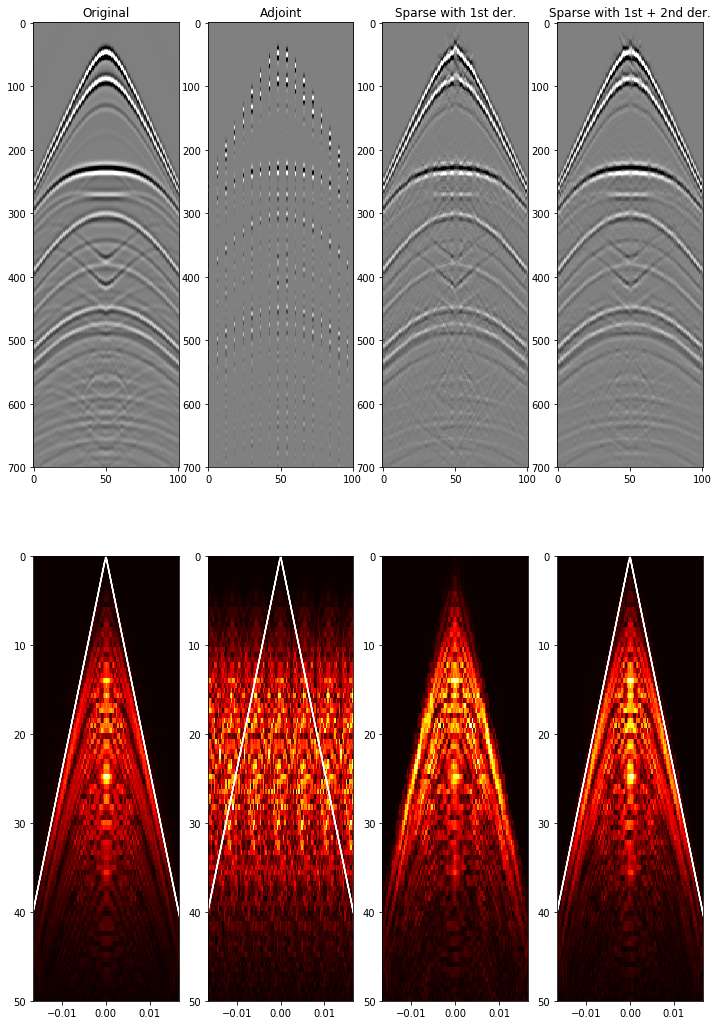

In [32]:
D = np.fft.fftshift(np.fft.fft2(d))
Dadj = np.fft.fftshift(np.fft.fft2(dadj))
Dinv1_s = np.fft.fftshift(np.fft.fft2(dinv1_s))
Dinv2_s = np.fft.fftshift(np.fft.fft2(dinv2_s))

fig, axs = plt.subplots(2, 4, figsize=(12, 18))
axs[0,0].imshow(d, cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[0,0].set_title('Original')
axs[0,1].imshow(dadj, cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0,1].set_title('Adjoint')
axs[0,2].imshow(np.real(dinv1_s),cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0,2].set_title('Sparse with 1st der.')
axs[0,3].imshow(np.real(dinv2_s),cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0,3].set_title('Sparse with 1st + 2nd der.')

axs[1,0].imshow(np.abs(D)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,0].plot(f/v, f,'w'), axs[1,0].plot(f/v, -f,'w')
axs[1,0].set_xlim(-1/(2*dx), 1/(2*dx));
axs[1,0].set_ylim(50, 0);
axs[1,1].imshow(np.abs(Dadj)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,1].plot(f/v, f,'w'), axs[1,1].plot(f/v, -f,'w')
axs[1,1].set_xlim(-1/(2*dx), 1/(2*dx));
axs[1,1].set_ylim(50, 0)
axs[1,2].imshow(np.abs(Dinv1_s)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,2].set_ylim(50, 0)
axs[1,3].imshow(np.abs(Dinv2_s)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,3].plot(f/v, f,'w'), axs[1,3].plot(f/v, -f,'w')
axs[1,3].set_xlim(-1/(2*dx), 1/(2*dx))
axs[1,3].set_ylim(50, 0);

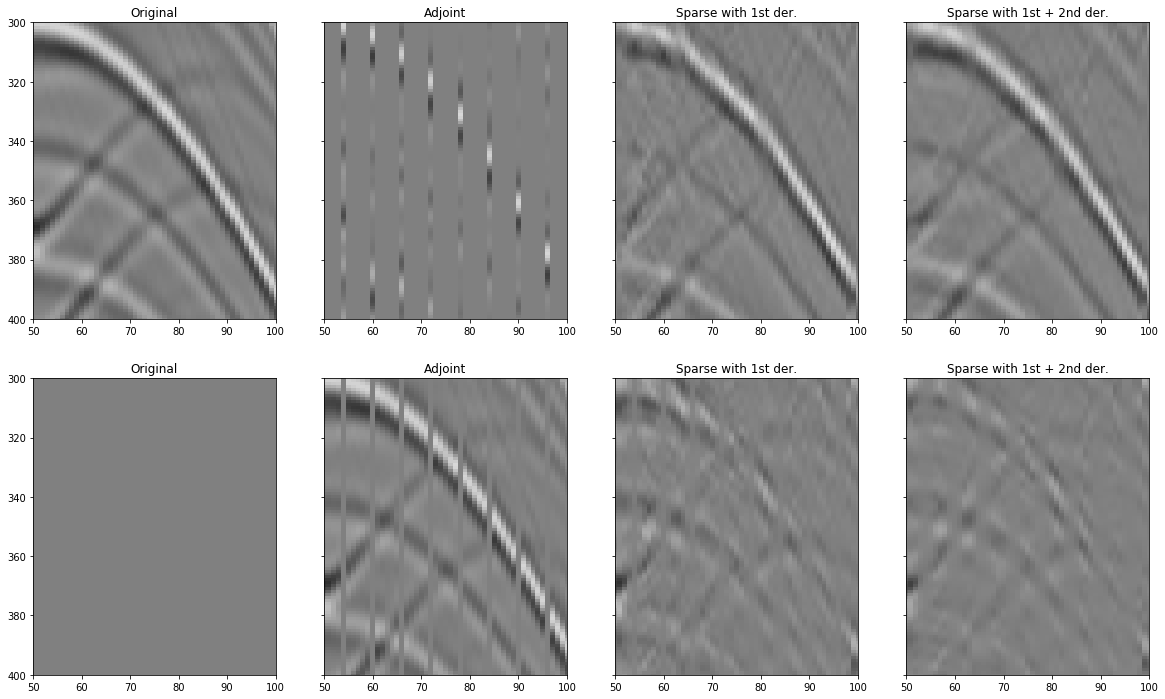

In [33]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(20, 12))
axs[0, 0].imshow(d, cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[0, 0].set_title('Original')
axs[0, 0].set_xlim(50, 100)
axs[0, 1].imshow(dadj, cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0, 1].set_title('Adjoint')
axs[0, 1].set_xlim(50, 100)
axs[0, 2].imshow(np.real(dinv1_s), cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0, 2].set_title('Sparse with 1st der.')
axs[0, 2].set_xlim(50, 100)
axs[0, 3].imshow(np.real(dinv2_s), cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0, 3].set_title('Sparse with 1st + 2nd der.')
axs[0, 3].set_xlim(50, 100)
axs[0, 3].set_ylim(400, 300)
axs[1, 0].imshow(d-d, cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[1, 0].set_title('Original')
axs[1, 0].set_xlim(50, 100)
axs[1, 1].imshow(d-dadj, cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[1, 1].set_title('Adjoint')
axs[1, 1].set_xlim(50, 100)
axs[1, 2].imshow(d-np.real(dinv1_s), cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[1, 2].set_title('Sparse with 1st der.')
axs[1, 2].set_xlim(50, 100)
axs[1, 3].imshow(d-np.real(dinv2_s), cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[1, 3].set_title('Sparse with 1st + 2nd der.')
axs[1, 3].set_xlim(50, 100)
axs[1, 3].set_ylim(400, 300);

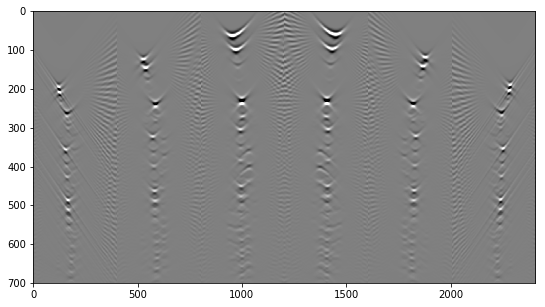

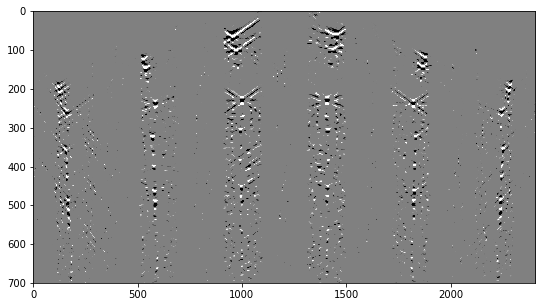

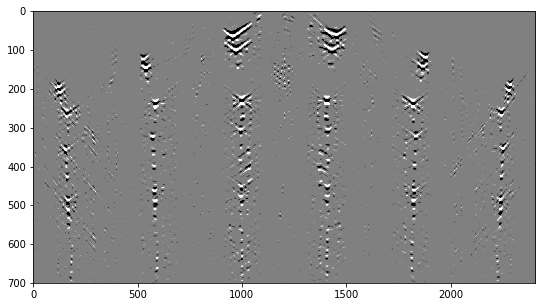

In [34]:
pinv1_s = pinv1_s.reshape(npx*nwins, nt)
pinv2_s = pinv2_s.reshape(npx*nwins, nt)

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.imshow(d_radon.T, cmap='gray', vmin=-1e1, vmax=1e1)
ax.axis('tight');

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.imshow(pinv1_s.T, cmap='gray', vmin=-1e-2, vmax=1e-2)
ax.axis('tight');

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.imshow(pinv2_s.T, cmap='gray', vmin=-1e-2, vmax=1e-2)
ax.axis('tight');

#### Errors

In [35]:
err_inv1_ft = np.linalg.norm(d-dinv1_s)
err_inv2_ft = np.linalg.norm(d-dinv2_s)

print(err_inv1_ft)
print(err_inv2_ft)

29.778728197348933
21.302146700422124


## Inversion with slopes

First we extract the nonaliased frequencies on which we will estimate slopes

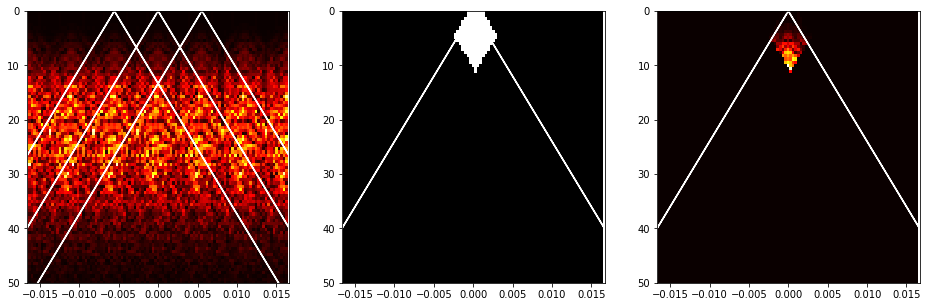

In [36]:
aliasmask = (np.abs(kx) < (critical*np.abs(ff)/vel + koffset)) & \
    (kx > (critical*np.abs(ff)/vel - 1./(subsampling*dx) + koffset)) & \
    (-kx > (critical*np.abs(ff)/vel - 1./(subsampling*dx) + koffset))
aliasmask = aliasmask.T
aliasmask = aliasmask.astype(np.int)

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(np.abs(Dadj)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[0].plot(f/v, f,'w'), axs[0].plot(f/v, -f,'w')
axs[0].plot(f/v - 1./(subsampling*dx), f,'w'), axs[0].plot(f/v + 1./(subsampling*dx), -f,'w')
axs[0].plot(-f/v - 1./(subsampling*dx), f,'w'), axs[0].plot(-f/v + 1./(subsampling*dx), -f,'w')
axs[0].set_xlim(-1/(2*dx), 1/(2*dx));
axs[0].set_ylim(50, 0);
axs[1].imshow(np.fft.ifftshift(aliasmask)[nt//2:], cmap='gray',aspect='auto',
              extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1].plot(f/v, f,'w'), axs[1].plot(f/v, -f,'w')
axs[1].set_xlim(-1/(2*dx), 1/(2*dx));
axs[1].set_ylim(50, 0)
axs[2].imshow(((np.fft.ifftshift(aliasmask))*np.abs(D))[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[2].plot(f/v, f,'w'), axs[2].plot(f/v, -f,'w')
axs[2].set_xlim(-1/(2*dx), 1/(2*dx));
axs[2].set_ylim(50, 0);

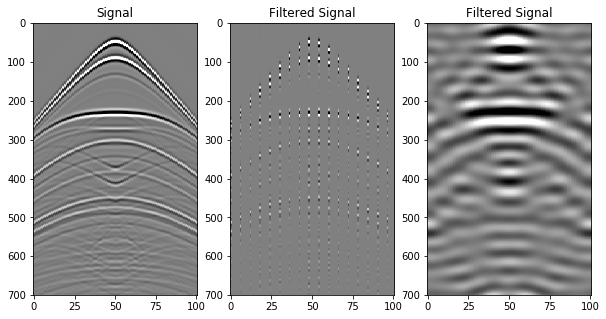

In [84]:
dmask = F.H * Diagonal(aliasmask.ravel()) * F * dadj.ravel()
dmask = np.real(dmask.reshape(nt, nr))

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(d, vmin=-1, vmax=1, cmap='gray')
axs[0].set_title('Signal')
axs[0].axis('tight')
axs[1].imshow(dadj, vmin=-1, vmax=1, cmap='gray')
axs[1].set_title('Filtered Signal')
axs[1].axis('tight');
axs[2].imshow(dmask, vmin=-0.01, vmax=0.01, cmap='gray')
axs[2].set_title('Filtered Signal')
axs[2].axis('tight');

### Slope estimation

Let's start from the finely sampled data

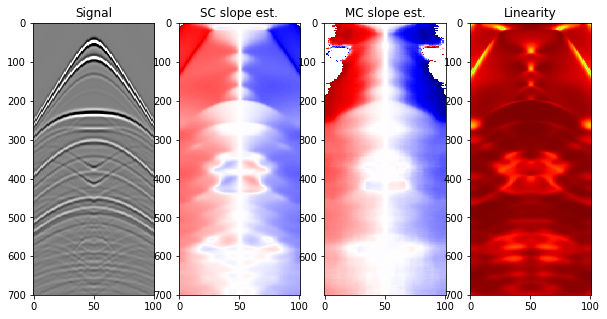

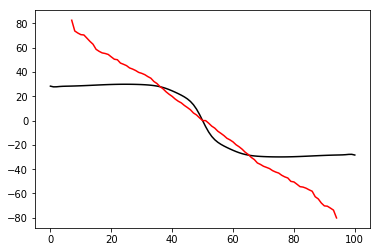

In [83]:
# Single component slope
slope_sc, linearity = slope_estimate(d, dt, dx, smooth=5)[:2]
                          
# Multi component slope
slope_mc = np.real(d1[:-1]) / (np.diff(d, axis=0) / dt)
slope_mc[np.isinf(slope_mc)] = 0
slope_mc[np.isnan(slope_mc)] = 0
slope_mc = median_filter(slope_mc, size=30)

# These two method estimate px=sin(theta)/v... we can then estimate the angle of incidence of wavefield..
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
axs[0].imshow(d, vmin=-1, vmax=1, cmap='gray')
axs[0].set_title('Signal')
axs[0].axis('tight')
axs[1].imshow(np.rad2deg(np.arcsin(slope_sc * v)), vmin=-90, vmax=90, cmap='seismic')
axs[1].set_title('SC slope est.')
axs[1].axis('tight')
im = axs[2].imshow(np.rad2deg(np.arcsin(slope_mc * v)), vmin=-90, vmax=90, cmap='seismic')
axs[2].set_title('MC slope est.')
axs[2].axis('tight')
im = axs[3].imshow(linearity, cmap='jet')
axs[3].set_title('Linearity')
axs[3].axis('tight')

plt.figure()
plt.plot(np.rad2deg(np.arcsin(slope_sc * v))[150], 'k')
plt.plot(np.rad2deg(np.arcsin(slope_mc * v))[150], 'r');

Now we consider the data at available spatial sampling low passed to the non-aliased fk diamond

In [39]:
from scipy.ndimage import gaussian_filter

def slope_estimate1(d, dz, dx, smooth=20, firstdir=True):
    """Estimate local slopes and linearity using 
    Structure Tensor algorithm (Van Vliet and Verbeek, 1995)
    """
    nz, nx = d.shape
    gz, gx = np.gradient(d, dz, dx)
    gzz, gzx, gxx = gz*gz, gz*gx, gx*gx

    # smoothing
    gzz = gaussian_filter(gzz, sigma=smooth)
    gzx = gaussian_filter(gzx, sigma=smooth)
    gxx = gaussian_filter(gxx, sigma=smooth)

    dirs = np.zeros((2, nz, nx))
    eigs = np.zeros((2, nz, nx))
    eigens = np.zeros((2, 2, nz, nx))
    slopes = np.zeros((nz, nx))
    linearity = np.zeros((nz, nx))
    for iz in range(nz):
        for ix in range(nx):
            T = np.array([[gzz[iz, ix], gzx[iz, ix]],
                          [gzx[iz, ix], gxx[iz, ix]]])
            E, U = np.linalg.eigh(T) # eigh puts eigenvalues in ascending order
            eigs[:, iz, ix] = E
            eigens[:, :, iz, ix] = U
            u = U[1] # eigenvector of max variation/ min coherency (orthogonal to feature) 
            v = U[0] # eigenvector of min variation/ max coherency (parallel to feature)
            if firstdir:
                dirs[:, iz, ix] = v
            else:
                dirs[:, iz, ix] = u
            slopes[iz, ix] = np.arctan(u[1] / u[0])
            linearity[iz, ix] = (np.max(E) - np.min(E))/np.max(E) 
    return slopes, linearity, dirs, eigs, eigens

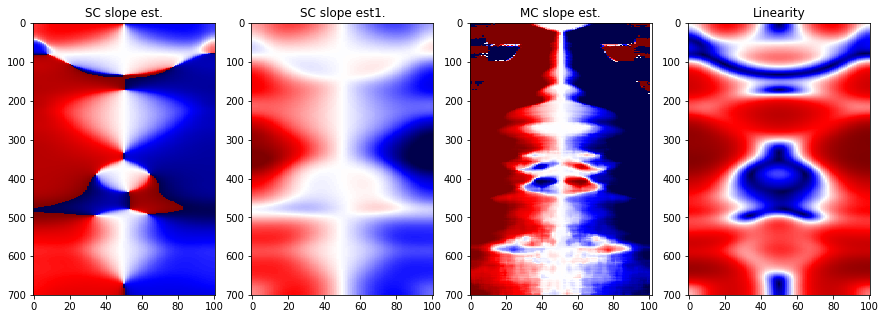

In [91]:
# Single component slope
slope_sc, linearity, dirs_parallel, eigs, eigens = slope_estimate1(dmask, 1, 1, smooth=15, firstdir=True)
slope_sc1 = slope_estimate1(dmask, dt, dx, smooth=15)[0]
#slope_sc1 = slope_estimate(dmask, dt, dx, smooth=5)[0]

# Multi component slope
slope_mc = np.real(d1[:-1]) / (np.diff(d, axis=0) / dt)
#slope_mc = (np.diff(d, axis=1) / dx)[:-1] / (np.diff(d, axis=0) / dt)[:, :-1]
slope_mc[np.isinf(slope_mc)] = 0
slope_mc[np.isnan(slope_mc)] = 0
slope_mc = median_filter(slope_mc, size=20)
slope_mc = np.pad(slope_mc, ((0, 1), (0, 1)))

fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].imshow(np.rad2deg(slope_sc), vmin=-90, vmax=90, cmap='seismic')
axs[0].set_title('SC slope est.')
axs[0].axis('tight')
axs[1].imshow(np.rad2deg(slope_sc1) * dx / dt, vmin=-90, vmax=90, cmap='seismic')
axs[1].set_title('SC slope est1.')
axs[1].axis('tight')
axs[2].imshow(np.rad2deg(slope_mc) * dx / dt, vmin=-90, vmax=90, cmap='seismic')
axs[2].set_title('MC slope est.')
axs[2].axis('tight');
axs[3].imshow(linearity, cmap='seismic')
axs[3].set_title('Linearity')
axs[3].axis('tight');

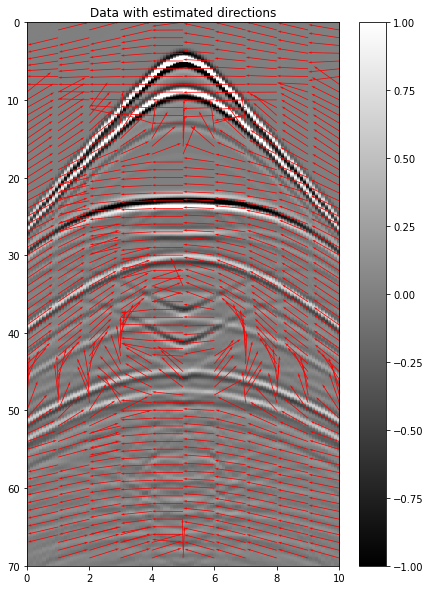

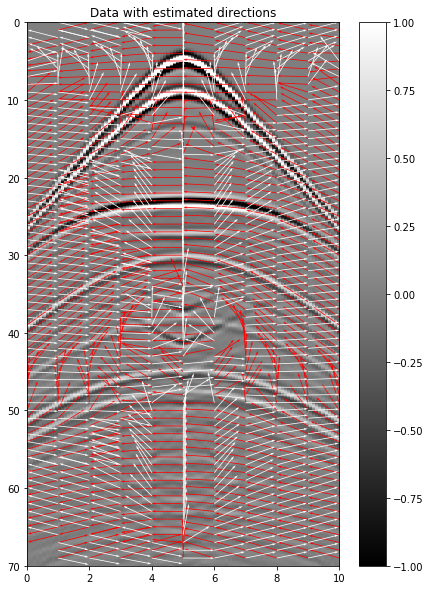

In [57]:
jump = 10
fig, ax = plt.subplots(figsize=(7, 10))
im = ax.imshow(d, cmap='gray',  vmin=-1, vmax=1,
               extent = (0, nr//jump, nt//jump, 0))
q = ax.quiver(dirs_parallel[1, ::jump, ::jump], 
              dirs_parallel[0, ::jump, ::jump], color='r', scale=jump, angles='xy')

ax.axis('tight')
ax.set_title('Data with estimated directions')
plt.colorbar(im, ax=ax);

fig, ax = plt.subplots(figsize=(7, 10))
im = ax.imshow(d, cmap='gray',  vmin=-1, vmax=1,
               extent = (0, nr//jump, nt//jump, 0))
q = ax.quiver(eigens[0, 1, ::jump, ::jump], 
              eigens[0, 0, ::jump, ::jump], color='r', scale=jump, angles='xy')
q = ax.quiver(eigens[1, 1, ::jump, ::jump], 
              eigens[1, 0, ::jump, ::jump], color='w', scale=jump, angles='xy')
ax.axis('tight')
ax.set_title('Data with estimated directions')
plt.colorbar(im, ax=ax);

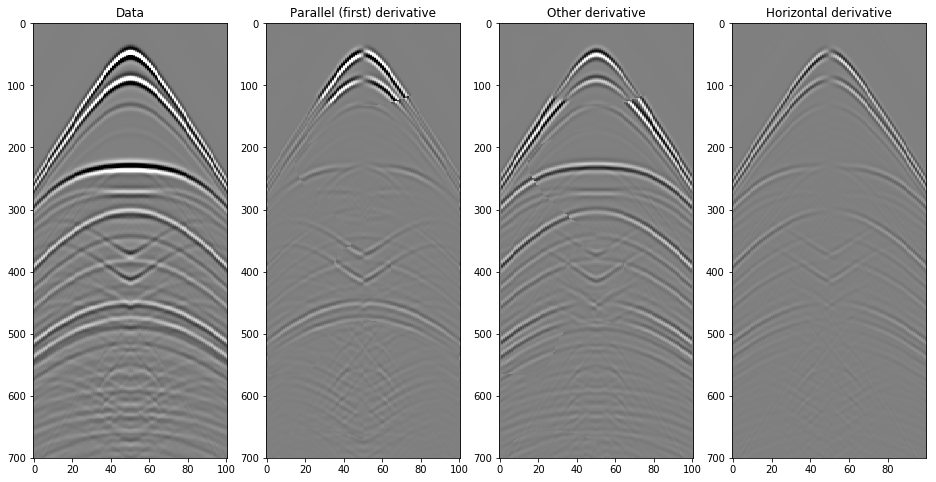

In [58]:
Dpop = FirstDirectionalDerivative((nt, nr), v=dirs_parallel, dtype='complex')
#Dpop = FirstDirectionalDerivative((nt, nr), v=eigens[0], dtype='complex')
Dnop = FirstDirectionalDerivative((nt, nr), v=eigens[1], dtype='complex')

dp = Dpop * d.ravel()
dp = dp.reshape(nt, nr)
dn = Dnop * d.ravel()
dn = dn.reshape(nt, nr)

fig, axs = plt.subplots(1, 4, figsize=(16, 8))
axs[0].imshow(d, cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[0].set_title('Data')
axs[1].imshow(np.real(dp), cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[1].set_title('Parallel (first) derivative')
axs[2].imshow(np.real(dn), cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[2].set_title('Other derivative');
axs[3].imshow(np.diff(d, axis=1)/dx, cmap='gray', aspect='auto', vmin=-0.1, vmax=0.1)
axs[3].set_title('Horizontal derivative');

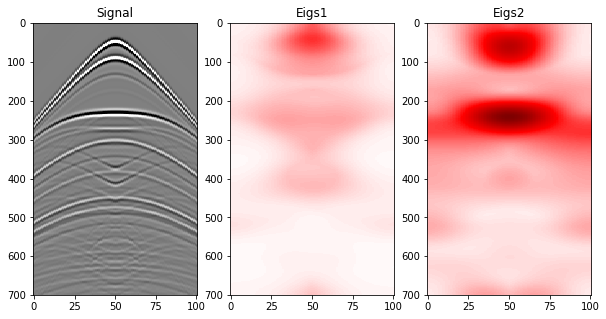

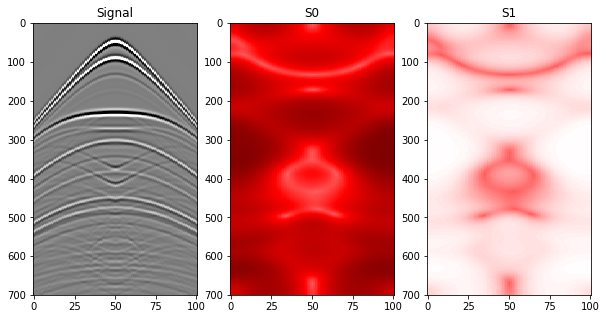

In [59]:
s0 = (1 - 0.5 * eigs[0] / eigs[1]) * np.exp(-0.5 * eigs[0] / eigs[1])
s1 = 0.5 * (eigs[0] / eigs[1]) ** 2 * np.exp(-0.5 * eigs[0] / eigs[1])

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(d, vmin=-1, vmax=1, cmap='gray')
axs[0].set_title('Signal')
axs[0].axis('tight')
im = axs[1].imshow(eigs[0], vmin=-np.max(eigs[1]), vmax=np.max(eigs[1]), cmap='seismic')
axs[1].set_title('Eigs1')
axs[1].axis('tight');
im = axs[2].imshow(eigs[1], vmin=-np.max(eigs[1]), vmax=np.max(eigs[1]), cmap='seismic')
axs[2].set_title('Eigs2')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(d, vmin=-1, vmax=1, cmap='gray')
axs[0].set_title('Signal')
axs[0].axis('tight')
im = axs[1].imshow(s0, vmin=-np.max(s0), vmax=np.max(s0), cmap='seismic')
axs[1].set_title('S0')
axs[1].axis('tight');
im = axs[2].imshow(s1, vmin=-np.max(s0), vmax=np.max(s0), cmap='seismic')
axs[2].set_title('S1')
axs[2].axis('tight');

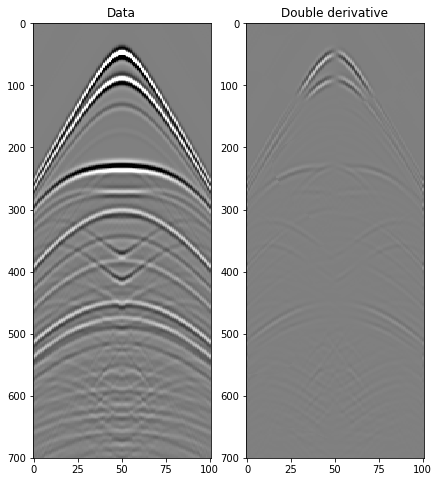

In [96]:
Dpop = Diagonal(s0.ravel()) * \
    FirstDirectionalDerivative((nt, nr), v=eigens[0], dtype='complex') + \
    Diagonal(s1.ravel()) * \
    FirstDirectionalDerivative((nt, nr), v=eigens[1], dtype='complex')

Dpop = Diagonal(linearity.ravel()) * Dpop

dp = Dpop * d.ravel()
dp = np.real(dp.reshape(nt, nr))

fig, axs = plt.subplots(1, 2, figsize=(7, 8))
axs[0].imshow(d, cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[0].set_title('Data')
axs[1].imshow(dp, cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[1].set_title('Double derivative');

In [98]:
eps_dir = 5e-1

# Inverse with FISTA
Forward = VStack([R, eps_dir*Dpop]) * F.H * Mf * F  * Sparseop
Forward.dtype = np.float
rhs = np.hstack([d_dec, np.zeros(nt*nr)])

pinv_dirs, _, cost = FISTA(Forward, rhs, niter=100, eps=1e-1, 
                           eigsiter=5, eigstol=1e-2,
                           returninfo=True, show=True)
dinv_dirs = np.real(Sparseop * pinv_dirs).reshape(nt, nr)

FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 82600 rows and 1684200 cols
eps = 1.000000e-01	tol = 1.000000e-10	niter = 100
alpha = 8.236876e-04	thresh = 4.118438e-05
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   0.00000e+00   2.774e+02   2.967e+02   2.950e-01
     2   0.00000e+00   2.068e+02   2.412e+02   2.389e-01
     3   0.00000e+00   1.459e+02   1.955e+02   2.514e-01
     4   0.00000e+00   9.895e+01   1.625e+02   2.446e-01
     5   0.00000e+00   6.580e+01   1.412e+02   2.253e-01
     6   0.00000e+00   4.398e+01   1.288e+02   1.992e-01
     7   0.00000e+00   3.044e+01   1.220e+02   1.708e-01
     8   0.00000e+00   2.244e+01   1.183e+02   1.433e-01
     9   0.00000e+00   1.789e+01   1.161e+02   1.192e-01
    10   0.00000e+00   1.537e+01   1.143e+02   1.001e-01
    11   0.00000e+00   1.395e+01   1.123e+02   8.650e-02
    21   0.00000

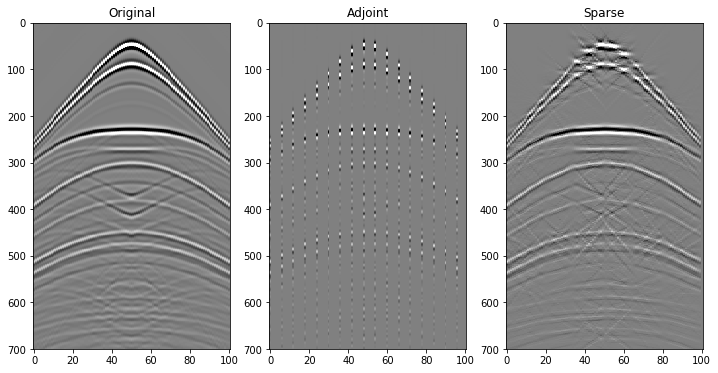

In [99]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(d, cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[0].set_title('Original')
axs[1].imshow(dadj, cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[1].set_title('Adjoint')
axs[2].imshow(np.real(dinv_dirs),cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[2].set_title('Sparse');

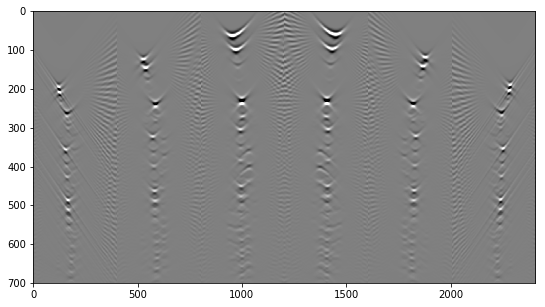

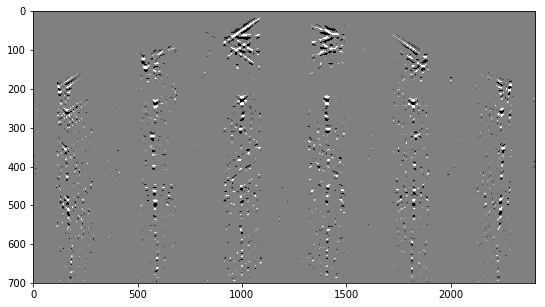

In [100]:
pinv_dirs = pinv_dirs.reshape(npx*nwins, nt)

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.imshow(d_radon.T, cmap='gray', vmin=-1e1, vmax=1e1)
ax.axis('tight');

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.imshow(pinv_dirs.T, cmap='gray', vmin=-1e-2, vmax=1e-2)
ax.axis('tight');

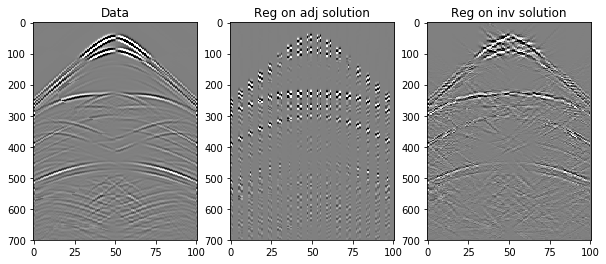

In [101]:
reg_d = Dpop * d.ravel()
reg_adj = Dpop * dadj.ravel()
reg_inv = Dpop * dinv_dirs.ravel()
reg_d = reg_d.reshape(nt, nr)
reg_adj = reg_adj.reshape(nt, nr)
reg_inv = reg_inv.reshape(nt, nr)

fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].imshow(np.real(reg_d), cmap='gray', vmin=-0.1, vmax=0.1)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(np.real(reg_adj), cmap='gray', vmin=-0.1, vmax=0.1)
axs[1].set_title('Reg on adj solution')
axs[1].axis('tight')
axs[2].imshow(np.real(reg_inv), cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].set_title('Reg on inv solution')
axs[2].axis('tight');

In [102]:
err_inv_fsl = np.linalg.norm(d - dinv_dirs)
print(err_inv_fsl)

40.37102157257365


In [103]:
d2_dec = np.real(R * d2.ravel())
d1_dec = np.real(R * d1.ravel())

Forward1 = VStack([R*F.H, sc1*R*F.H*D1op_hand, eps_dir*Dpop*F.H]) * Mf * F * Sparseop
Forward1.dtype = np.float
rhs1 = np.concatenate((d_dec, sc1*d1_dec, np.zeros(nt*nr)))

Forward2 = VStack([R*F.H, sc1*R*F.H*D1op_hand, sc2*R*F.H*D2op_hand, eps_dir*Dpop*F.H]) * Mf * F * Sparseop
Forward2.dtype = np.float
rhs2 = np.concatenate((d_dec, sc1*d1_dec, sc2*d2_dec, np.zeros(nt*nr)), axis=0)

# sparse solution
#pinv1_s, pspgl, info = SPGL1(Forward1, rhs1, **dict(iter_lim=100, verbosity=2))
#pinv2_s, pspgl2, info2 = SPGL1(Forward2, rhs2, **dict(iter_lim=100, verbosity=2))
pinv1_s, _, cost = FISTA(Forward1, rhs1, niter=100, eps=1e-1, 
                          eigsiter=5, eigstol=1e-2,
                          returninfo=True, show=True)
pinv2_s, _, cost2 = FISTA(Forward2, rhs2, niter=100, eps=1e-1, 
                          eigsiter=5, eigstol=1e-2,
                          returninfo=True, show=True)

dinv1_s = np.real(F.H * Mf * F * Sparseop * pinv1_s).reshape(nt,nr)
dinv2_s = np.real(F.H * Mf * F * Sparseop * pinv2_s).reshape(nt,nr)

FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 94500 rows and 1684200 cols
eps = 1.000000e-01	tol = 1.000000e-10	niter = 100
alpha = 5.972668e-04	thresh = 2.986334e-05
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1  -7.30159e-05   5.128e+02   5.433e+02   4.868e-01
     2  -6.50253e-05   3.741e+02   4.221e+02   2.990e-01
     3  -2.87812e-05   2.704e+02   3.340e+02   2.893e-01
     4   0.00000e+00   1.930e+02   2.704e+02   2.758e-01
     5   0.00000e+00   1.365e+02   2.258e+02   2.580e-01
     6   0.00000e+00   9.635e+01   1.956e+02   2.365e-01
     7   0.00000e+00   6.862e+01   1.758e+02   2.128e-01
     8   0.00000e+00   4.994e+01   1.632e+02   1.888e-01
     9   0.00000e+00   3.762e+01   1.551e+02   1.658e-01
    10   0.00000e+00   2.967e+01   1.498e+02   1.447e-01
    11   0.00000e+00   2.461e+01   1.461e+02   1.260e-01
    21   0.00000

### Visualization

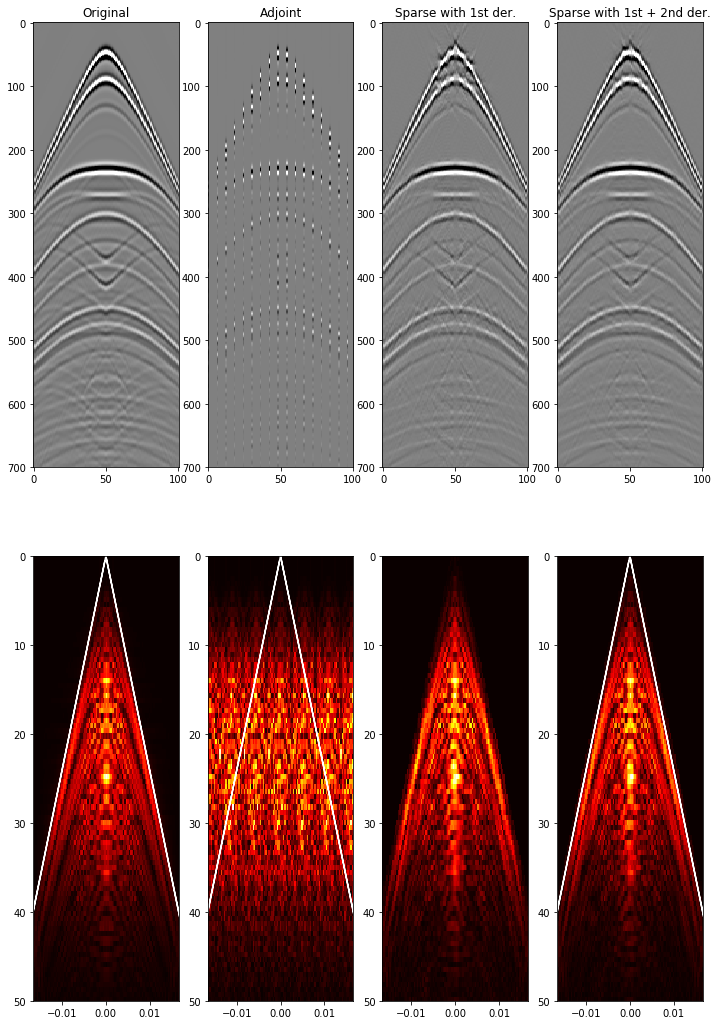

In [104]:
D = np.fft.fftshift(np.fft.fft2(d))
Dadj = np.fft.fftshift(np.fft.fft2(dadj))
Dinv1_s = np.fft.fftshift(np.fft.fft2(dinv1_s))
Dinv2_s = np.fft.fftshift(np.fft.fft2(dinv2_s))

fig, axs = plt.subplots(2, 4, figsize=(12, 18))
axs[0,0].imshow(d, cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[0,0].set_title('Original')
axs[0,1].imshow(dadj, cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0,1].set_title('Adjoint')
axs[0,2].imshow(np.real(dinv1_s),cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0,2].set_title('Sparse with 1st der.')
axs[0,3].imshow(np.real(dinv2_s),cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0,3].set_title('Sparse with 1st + 2nd der.')

axs[1,0].imshow(np.abs(D)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,0].plot(f/v, f,'w'), axs[1,0].plot(f/v, -f,'w')
axs[1,0].set_xlim(-1/(2*dx), 1/(2*dx));
axs[1,0].set_ylim(50, 0);
axs[1,1].imshow(np.abs(Dadj)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,1].plot(f/v, f,'w'), axs[1,1].plot(f/v, -f,'w')
axs[1,1].set_xlim(-1/(2*dx), 1/(2*dx));
axs[1,1].set_ylim(50, 0)
axs[1,2].imshow(np.abs(Dinv1_s)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,2].set_ylim(50, 0)
axs[1,3].imshow(np.abs(Dinv2_s)[nt//2:], cmap='hot',aspect='auto',
                extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nt//2-1], f[0]))
axs[1,3].plot(f/v, f,'w'), axs[1,3].plot(f/v, -f,'w')
axs[1,3].set_xlim(-1/(2*dx), 1/(2*dx))
axs[1,3].set_ylim(50, 0);

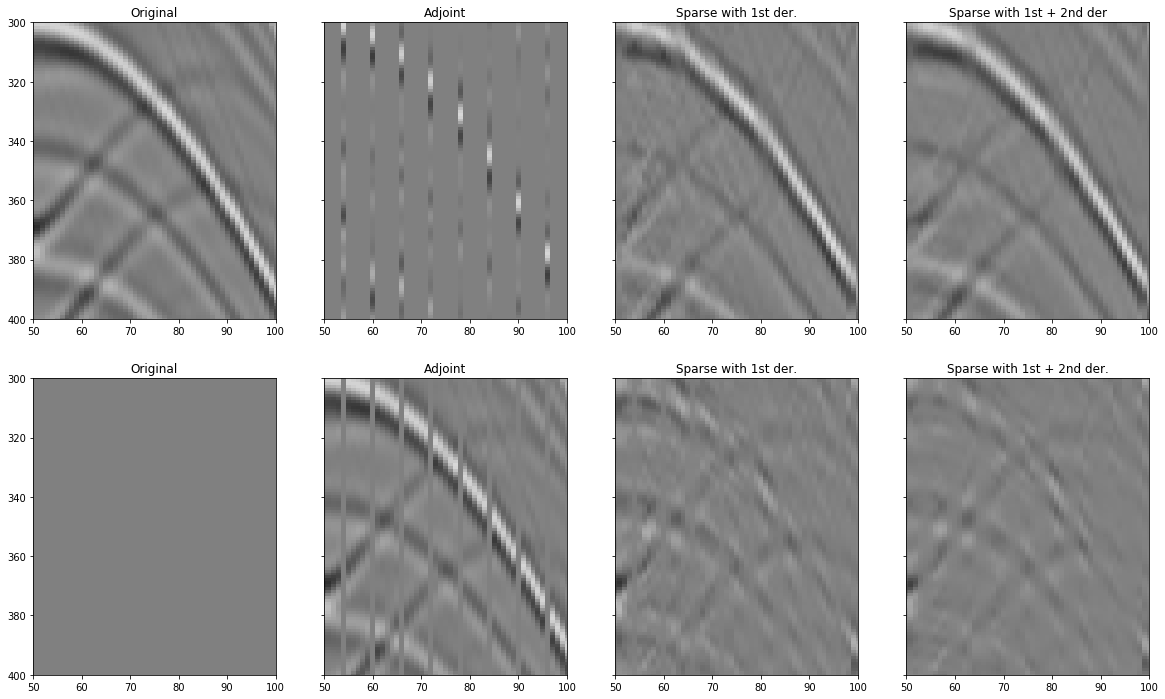

In [105]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(20, 12))
axs[0, 0].imshow(d, cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[0, 0].set_title('Original')
axs[0, 0].set_xlim(50, 100)
axs[0, 1].imshow(dadj, cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0, 1].set_title('Adjoint')
axs[0, 1].set_xlim(50, 100)
axs[0, 2].imshow(np.real(dinv1_s), cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0, 2].set_title('Sparse with 1st der.')
axs[0, 2].set_xlim(50, 100)
axs[0, 3].imshow(np.real(dinv2_s), cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[0, 3].set_title('Sparse with 1st + 2nd der')
axs[0, 3].set_xlim(50, 100)
axs[0, 3].set_ylim(400, 300)
axs[1, 0].imshow(d-d, cmap='gray', aspect='auto', vmin=-1, vmax=1)
axs[1, 0].set_title('Original')
axs[1, 0].set_xlim(50, 100)
axs[1, 1].imshow(d-dadj, cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[1, 1].set_title('Adjoint')
axs[1, 1].set_xlim(50, 100)
axs[1, 2].imshow(d-np.real(dinv1_s), cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[1, 2].set_title('Sparse with 1st der.')
axs[1, 2].set_xlim(50, 100)
axs[1, 3].imshow(d-np.real(dinv2_s), cmap='gray',aspect='auto', vmin=-1, vmax=1)
axs[1, 3].set_title('Sparse with 1st + 2nd der.')
axs[1, 3].set_xlim(50, 100)
axs[1, 3].set_ylim(400, 300);

#### Errors

In [106]:
err_inv1_ftsl = np.linalg.norm(d-dinv1_s)
err_inv2_ftsl = np.linalg.norm(d-dinv2_s)

print(err_inv1_ftsl)
print(err_inv2_ftsl)

27.769083285709137
20.75830100285511


## Errors comparison

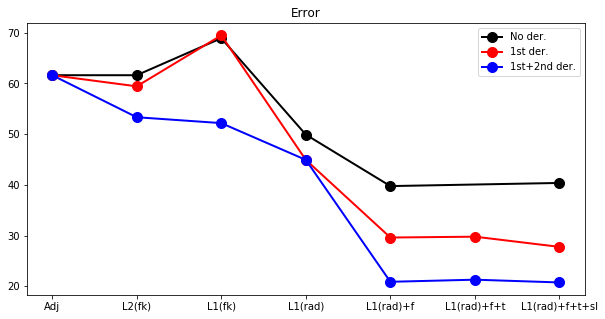

In [107]:
plt.figure(figsize=(10, 5))
plt.plot([0, 1, 2, 3, 4, 6], [err_adj, err_ls_fk, err_inv_fk, err_inv, err_inv_f, err_inv_fsl], 
         '.-k', ms=20, lw=2, label='No der.')
plt.plot(np.arange(7), [err_adj, err_ls1_fk, err_inv1_fk, err_inv1, err_inv1_f, err_inv1_ft, err_inv1_ftsl], '.-r', 
         ms=20, lw=2, label='1st der.')
plt.plot(np.arange(7), [err_adj, err_ls2_fk, err_inv2_fk, err_inv1, err_inv2_f, err_inv2_ft, err_inv2_ftsl], '.-b', 
         ms=20, lw=2, label='1st+2nd der.')
plt.xticks(np.arange(7), labels=['Adj', 'L2(fk)', 'L1(fk)',  'L1(rad)', 'L1(rad)+f', 
                   'L1(rad)+f+t', 'L1(rad)+f+t+sl'])
plt.title('Error');
plt.legend();